# Проект: Банки — Анализ оттока клиентов


**Цель проекта :**
Провести анализ клиентов банка, сегментировать клиентов, составить типичный портрет клеиентов для каждого сегмента и выделить сегменты, склонные к оттоку, выявить причины оттока
    

**План выполнения проекта:**
1. Загрузка и предобрработка данных: нормализация данных, проверка пропусков, дубликатов, аномалий
2. Исследовательский анализ данных (EDA)
    - распределение клиентов по признакам
    - распределение клиентов по признакам для оставшихся клиентов и тех, кто ушел
    - матрица корреляции признаков
3. Сегментация клиентов
    - портрет клиента каждого сегмента
    - выявление сегментов подверженные наибольшему оттоку
4. Проверка гипотез:
    - проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались
5. Общие выводы и рекомендации

In [6]:
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [10]:
import phik
from phik.report import plot_correlation_matrix
from phik import report


## Загрузка и предобрработка данных: проверка пропусков, дубликатов, типов данных

In [12]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
display(data)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


Приведем наименования столбцов к нижнему регистру и выведем информацию о датасете 

In [14]:
data.columns = map(str.lower, data.columns)


**Работа с пропусками и дубликатами**

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Всего в датасете 10000 записей. Все поля имеют соответствующие содержанию типы данных. Поле 'balance' имеет 2295 пропусков или почти 23% . Ввиду отсутствия данных в этой катгории и невозможности испоьзовать средние или медианные значения оставим пропуски как есть. Поле 'age' имеет только 26 строк с пропусками. Количество несущественное, 0,26%. Допустимо такие строки удалить

In [20]:
data = data.dropna(subset=['age']) 

Проверим датасет на наличие дубликатов по полям 'userid' и 'city'

In [23]:
display(data[data.duplicated(['userid', 'city'])])

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


дубликаты не выявлены

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9974 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9974 non-null   int64  
 1   score          9974 non-null   float64
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   float64
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1013.0+ KB


После очистки и заменеы пустых значений в датасете 9974 записи. Все поля имеют соответствующие их сожержанию типы данных. 

## Исследовательский анализ данных (EDA)

### Распределение клиентов по признакам

##### Оценка числовых полей

Для оценки числовых параметров выведем статистику датасета

In [33]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
display(data.describe())


,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9974.0,9974.0,9974.0,9974.0,7695.0,9974.0,9974.0,9974.0,9974.0,9974.0
mean,171755.2,848.7,42.7,2.6,827245.6,1.9,0.7,0.5,147786.8,0.2
std,33695.5,65.4,12.2,2.0,1980327.4,0.8,0.5,0.5,139285.5,0.4
min,94561.0,642.0,18.0,0.0,0.0,0.0,0.0,0.0,2546.3,0.0
25%,142760.0,802.0,33.0,0.0,295698.7,1.0,0.0,0.0,75251.7,0.0
50%,172643.0,853.0,40.0,3.0,524295.3,2.0,1.0,1.0,119626.8,0.0
75%,201163.8,900.0,51.0,4.0,980051.2,2.0,1.0,1.0,174499.8,0.0
max,229145.0,1000.0,86.0,9.0,119113552.0,5.0,1.0,1.0,1395064.4,1.0


Поля 'score','balance','est_salary' не содержат отрицательных значений, на данном этапе аномалии не выявлены

Поле 'score' — баллы кредитного скоринга. Минимальное значение 642, максимальное - 1000, среднее 848,7, медианное значение 853

Поле 'balance' - баланс на счете. Минимальное - 0, максимальное значение 119113552.0, среднее 827245.6, медианное 524295.3

Поле 'est_salary' - оценочный доход клиента. Минимальное - 2546,3, максимальное значение 1395064.4, среднее 147786.8, медианное 119626.8

Поля с бинарными значениями 'credit_card', 'last_activity', 'churn' не содержат аномалий, значения 0 или 1

по полю 'age' аномалии не выявлены, возраст клиентов находится в разумных рамках от 18 до 86 лет. Средний возраст 42,7, медианный возраст клиентов 40 лет.

по полю 'equity' аномалии не выявлены, количество баллов собственности от 0 до 9. Среднее 2,6, и медианное значение 3, очень близки. Вероятно подавляющее большинство клиентов имеют по 3 балла собственности

по полю 'products'аномалии не выявлены, минимальное количество продуктов 0, максимальное - 9.Среднее 1,9, и медианное значение 2, очень близки. Вероятно подабляющее большинство клиентов имеют по 2 продукта.

##### Распределение клиентов по признакам

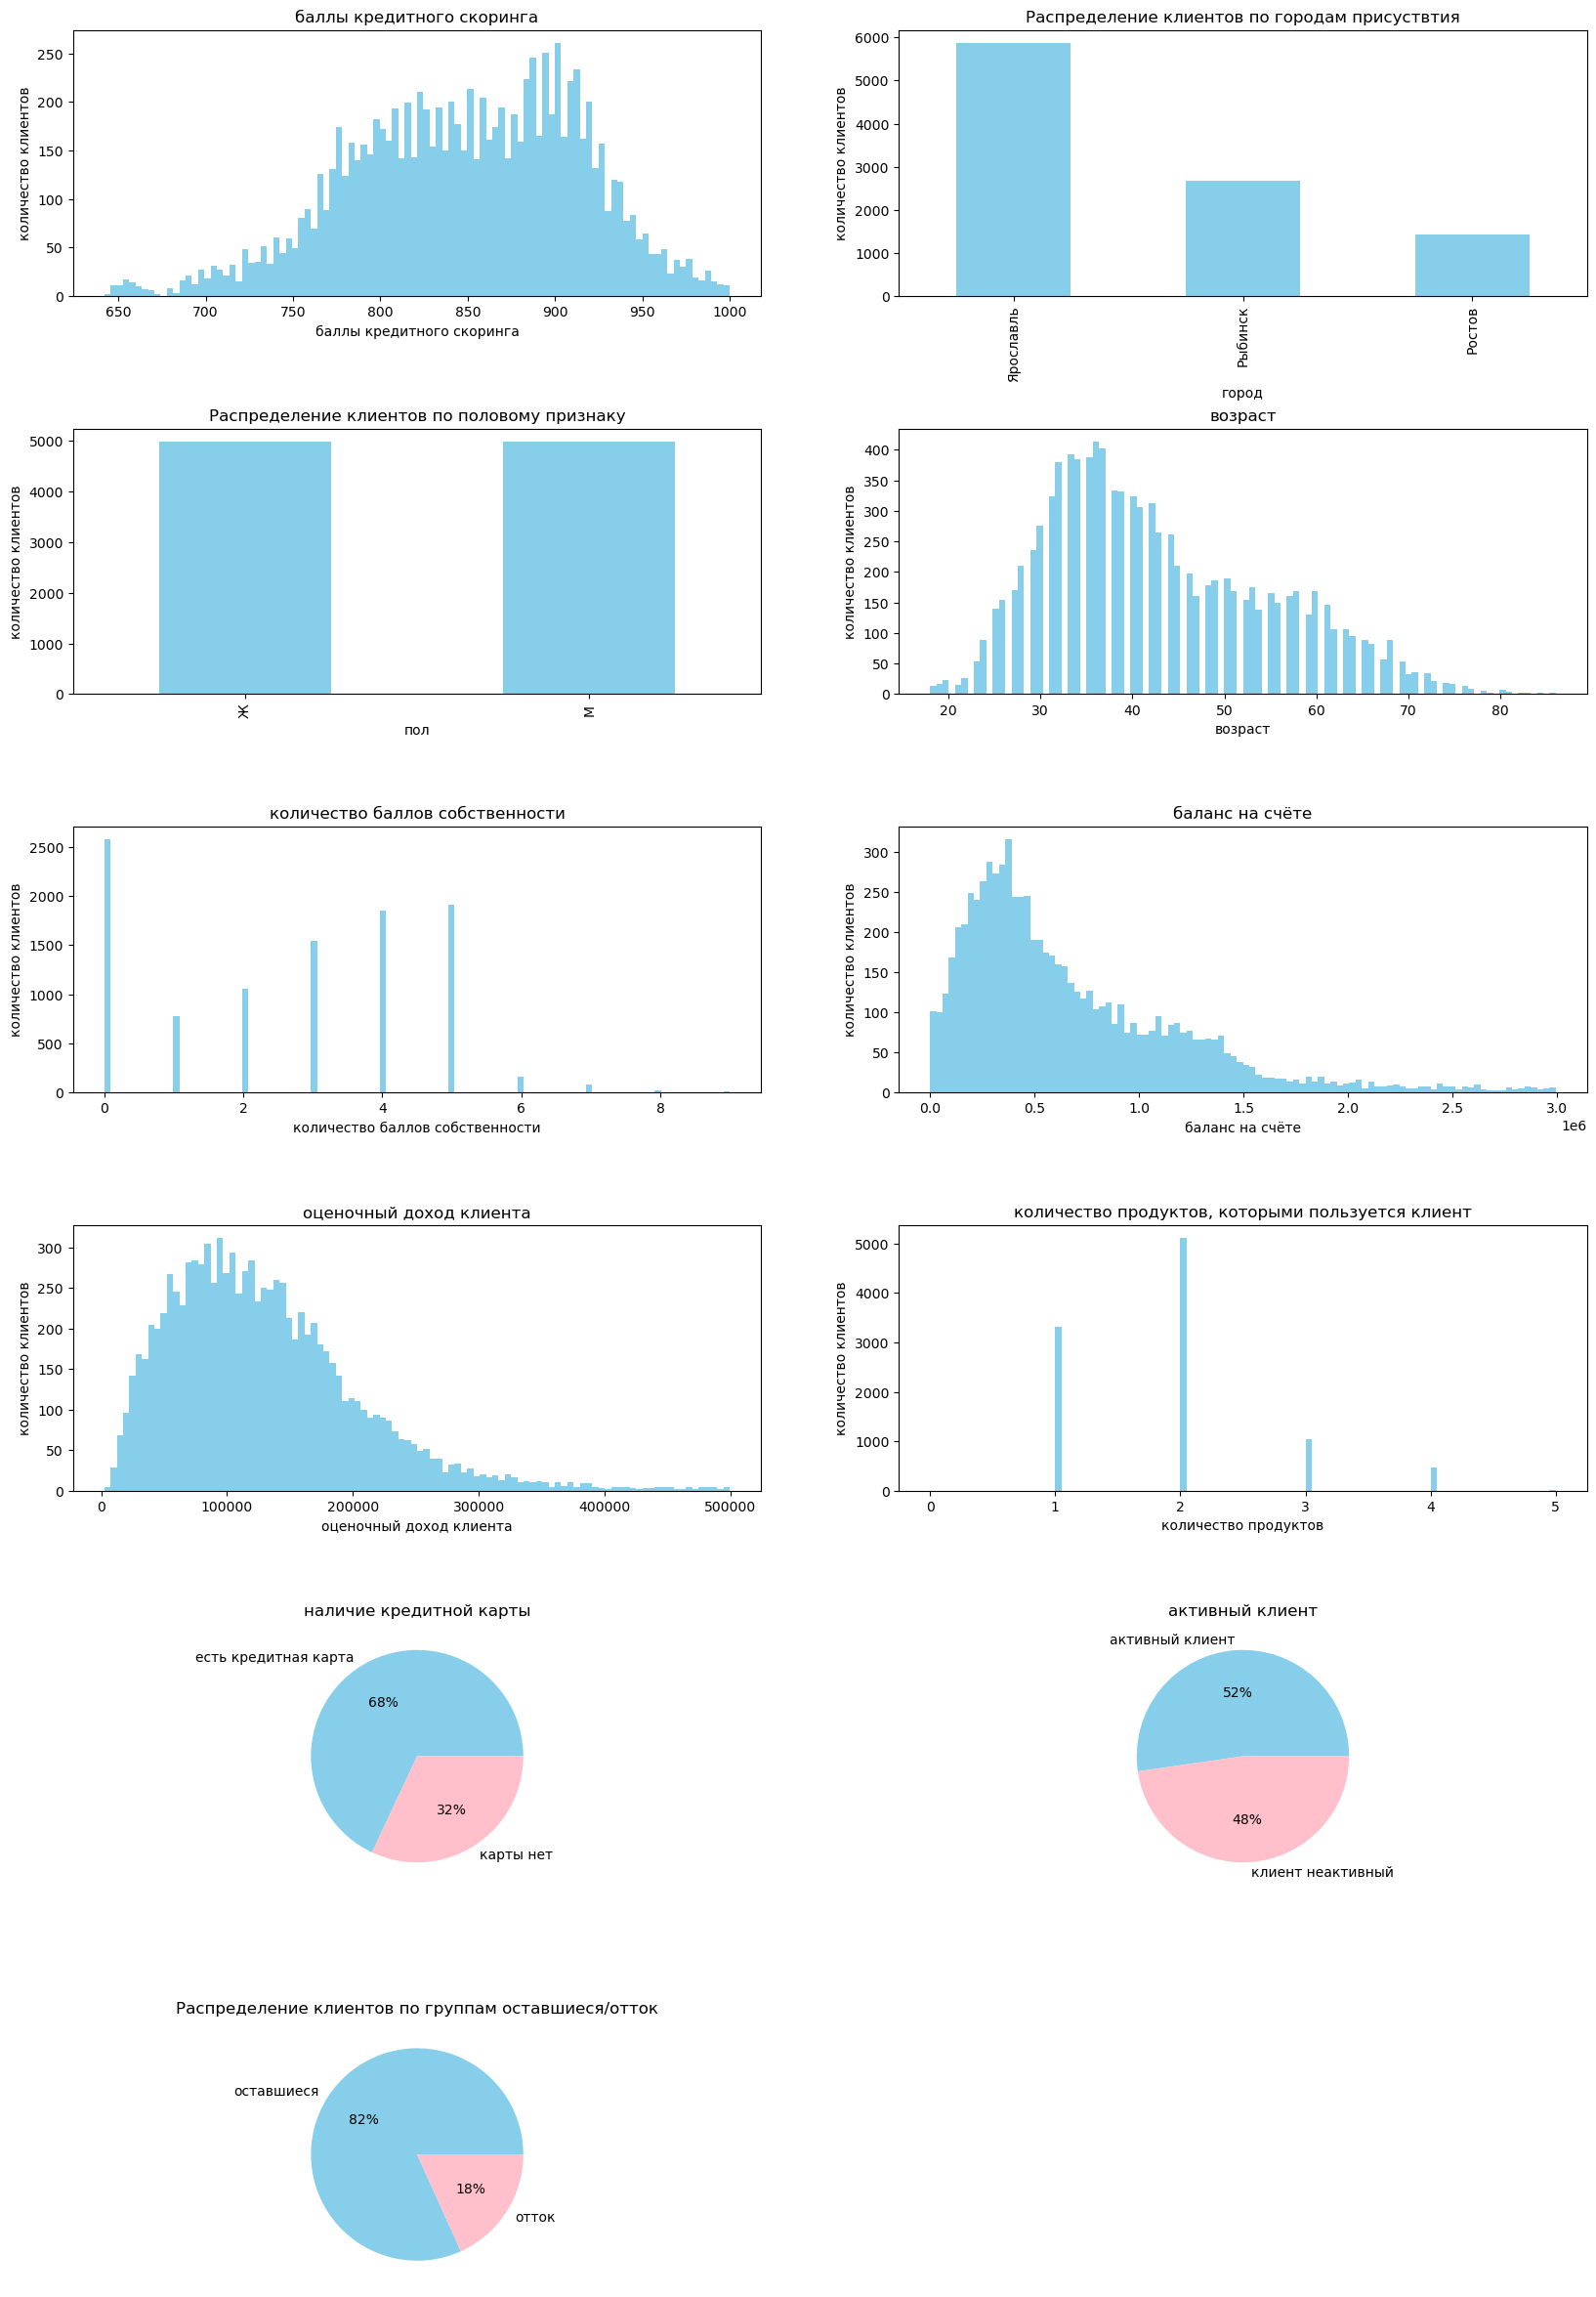

In [37]:

plt.subplot(6, 2, 1)
data['score'].plot(kind = 'hist',bins=100, color='skyblue', figsize = (20,30))
plt.title('баллы кредитного скоринга')
plt.xlabel('баллы кредитного скоринга')
plt.ylabel('количество клиентов')

plt.subplot(6, 2, 2)
data.groupby('city')['userid'].count().sort_values(ascending=False).plot(kind = 'bar', color='skyblue', figsize=(20,30))
plt.title('Распределение клиентов по городам присуствтия')
plt.xlabel('город')
plt.ylabel('количество клиентов')


plt.subplot(6, 2, 3)
data.groupby('gender')['userid'].count().plot(kind = 'bar', color='skyblue', figsize=(20,30))
plt.title('Распределение клиентов по половому признаку')
plt.xlabel('пол')
plt.ylabel('количество клиентов')



plt.subplot(6, 2, 4)
data['age'].plot(kind = 'hist',bins=100, color='skyblue', figsize = (20,30))
plt.title('возраст')
plt.xlabel('возраст')
plt.ylabel('количество клиентов')

plt.subplot(6, 2, 5)
data['equity'].plot(kind = 'hist',bins=100, color='skyblue', figsize = (20,30))
plt.title('количество баллов собственности')
plt.xlabel('количество баллов собственности')
plt.ylabel('количество клиентов')

plt.subplot(6, 2, 6)
data.query('balance <=3000000')['balance'].plot(kind = 'hist',bins=100, color='skyblue', figsize = (20,30))
plt.title('баланс на счёте')
plt.xlabel('баланс на счёте')
plt.ylabel('количество клиентов')

plt.subplot(6, 2, 7)
data.query('est_salary <=500000')['est_salary'].plot(kind = 'hist',bins=100, color='skyblue', figsize = (20,30))
plt.title('оценочный доход клиента')
plt.xlabel('оценочный доход клиента')
plt.ylabel('количество клиентов')

plt.subplot(6, 2, 8)
data['products'].plot(kind = 'hist',bins=100, color='skyblue', figsize = (20,30))
plt.title('количество продуктов, которыми пользуется клиент')
plt.xlabel('количество продуктов')
plt.ylabel('количество клиентов')


plt.subplot(6, 2, 9)
custom_labels = ['есть кредитная карта', 'карты нет']
colors = ['skyblue', 'pink']
data.groupby('credit_card')['userid'].count().sort_values(ascending = False).plot(kind = 'pie', figsize=(20,30), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('наличие кредитной карты')
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 10)
custom_labels = ['активный клиент', 'клиент неактивный']
colors = ['skyblue', 'pink']
data.groupby('last_activity')['userid'].count().sort_values(ascending = False).plot(kind = 'pie', figsize=(20,30), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
#data['last_activity'].hist(bins=100, figsize=(15,20))
plt.title('активный клиент')
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 11)
custom_labels = ['оставшиеся', 'отток']
colors = ['skyblue', 'pink']
data.groupby('churn')['userid'].count().sort_values(ascending = False).plot(kind = 'pie', figsize=(20,30), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')



plt.subplots_adjust(hspace=0.5)
plt.show()

Основная масса клиентов сконцентрирована по параметру баллов кредитного рейтинга в диапазоне от примерно 770 до примерно 980.

В выборке присутствует только 3 города: 'Рыбинск', 'Ярославль', 'Ростов'. Наибольшее количество клиентов в Ярославле 5875 клиентов, далее следует Рыбинск 2683 и Ростов - 1416 клиентов

Только 2 гендера 'Ж', 'М'. Клиенты банка по полу распределены примерно одинаково - 4983 и 4991 клиентов соответственно. 

Большинство клиентов по возрасту находятся в диапазоне от примерно 27 до примерно 50 лет.

По критерию количества баллов собственности наибольшая доля имеет оценку 0 баллов. Медиана по этому показателю составляет 3 балла собственности. Наличие 6-8 баллов имеет очень малая доля клиентов

Баланс большинства клиентов находится в диапазоне от примерно 50000-500000. Обращает на себя внимание большое количетсов лкиентов с нулевым или околонулевым остатком
 
Распределение оценочного дохода в большинстве своем распределено до 4000000, все что больше не многочисленны. Основная масса клиентов имеет оценочный доход в диапазоне примерно 75000-175000

Наибольшая часть клиентов банка пользуется двеся проудктами банка, реже имеет только 1 продукт.
 
По наличию кредитной карты приобладают среди клиентов ее обладатели 68% против 32% без кредитной карты.

Распределение клиентов по параметру активности близки, но преобладают активные клиенты - 52% против 48% неактивных клиентов

В группу отток попадают 18% всех клиентов или 1819 из 9974.

**Типичный клиента банка:** это активный клиент мужчина или женщина в возрасте 27-50 лет, с доходом 75000-175000, балансом счета 50000-500000, имеет 770-980 баллов кредитного скоринга, 4-5 баллов собственности, часто 0 баллов собственности, пользуется 2 банковскими продуктами, имеет кредитную карту

### Распределение клиентов по признакам в разрезе групп остались и отток

##### Оценка средникх значений клиентов оставшихся и отток

In [42]:
display(data.groupby('churn').mean(numeric_only=True))

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary
churn,,,,,,,,,
0,171928.1,845.4,43.0,2.4,733031.6,1.8,0.7,0.5,147674.6
1,170980.1,863.4,41.5,3.8,1134458.2,2.4,0.6,0.7,148289.7


Средние показатели в группах оставшихся и отток:

Баллы кредитного рейтинга группы оставшиеся 863,4, что выше чем у группы отток с средним показателем 845,4

Средний возраст оставшихся клиентов 41,5, что ниже чем у группы отток - 43,0

Количество баллов собственности у группы осташиеся 3,8, против 2,4 у группы отток

Баланс счета у группы оставшихся выше чем у группы отток, 1.126.350,5 против 529.346,8 

Количество продуктов у группы оставшиеся 2,4, тогда как у группы отток 1,8

Среднее количество кредитных карт у группы оставшиеся 0,6, что ниже чем у группы отток 0,7

Показатель активный клиент у группы оставшихся 0,7 выше чем у грыппы отток 0,5

Оценочный доход в группе оставшиеся 148.289,7 что даваольно близко к среднему показателю группы отток 147.674,6

Оставшиеся клиенты имеют выше балл кредитного рейтинга, большее  колличество баллов собственности, пользуются большим количеством продуктов, являются блее активными клиентами
Клиенты категории отток имеют больше кредитных карт

##### Распределение клиентов по категориальному признаку - поля 'gender', 'city' в группах остались и отток

Клиенты имебщие довольно высокий уровень кредитного реутинга в диапазоне приверно 850-900 

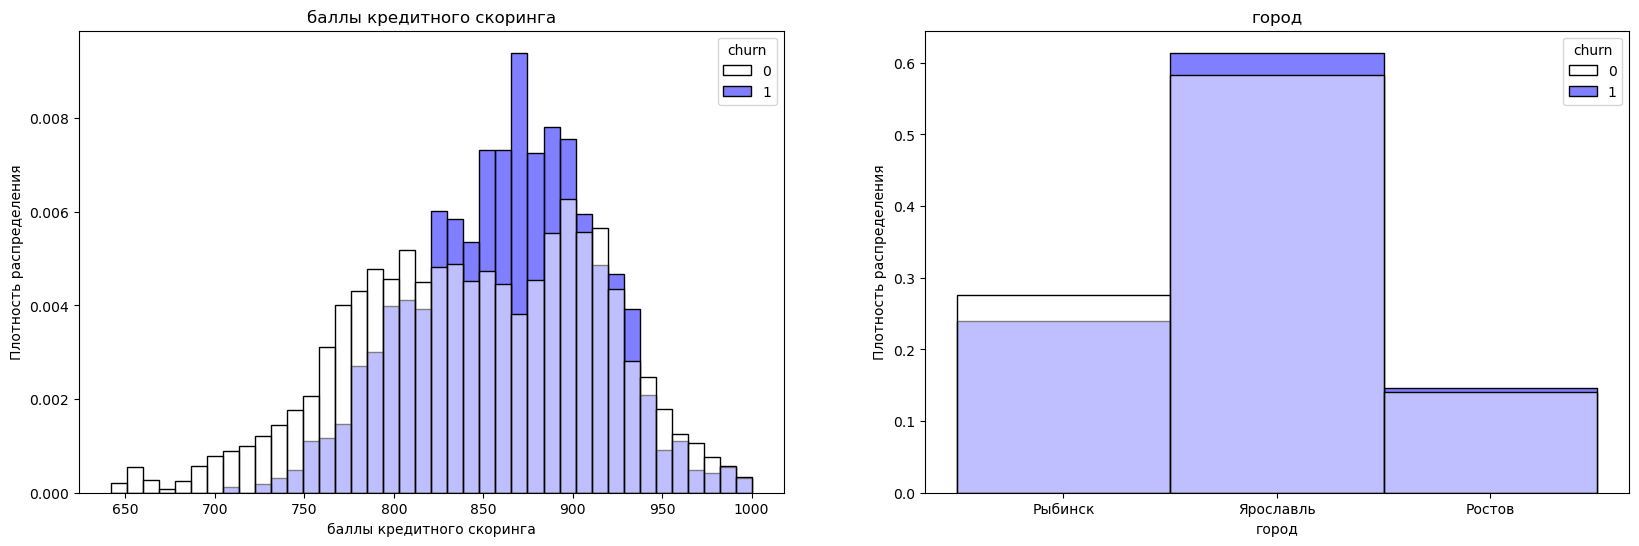

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 строка, 2 столбца
ax1, ax2 = axes  # Распаковка осей

sns.histplot(data=data, hue = 'churn', x = 'score', stat = 'density', common_norm = False, ax=ax1, palette = 'flag' )
ax1.set_title('баллы кредитного скоринга')
ax1.set_xlabel('баллы кредитного скоринга', fontsize=10)
ax1.set_ylabel('Плотность распределения')

sns.histplot(data=data, hue = 'churn', x = 'city', stat = 'density', common_norm = False, discrete=True, ax=ax2, palette = 'flag' )
ax2.set_title('город')
ax2.set_xlabel('город', fontsize=10)
ax2.set_ylabel('Плотность распределения')



plt.show()

На всем представленном диапазоне по баллам кредитного сокринга  клиенты имеют 600-1000 баллов.
От 600 до 830 преобладают вероятность что клиент останется, но с ростом балла кредитного скорина вероятность что клиент покинет банк преобладает. Так, в группу отток попадают клиенты с довольно высоким баллом кредитного скоринга. Диапазон баллов 830-930. Возможно низкорискованные клиенты с точки зрения оценки кредитных рисков являются желаными клиентами для многих банков, и вероятно другие банки могут переманивать тких клиентов лучшими условиями обслужмивания, т.ч. кредитования. Далее клиенты с самым высоким баллом кредитного рейтинга 930-1000 с большей долей вероятности остаются лкиентами банка. Веозможно, это "старые" клиенты с консервативной моделью поведения

Явной зависимости между группами остались и отток по городу присутствия не выявлено, доли клиентов группы отток небольшие



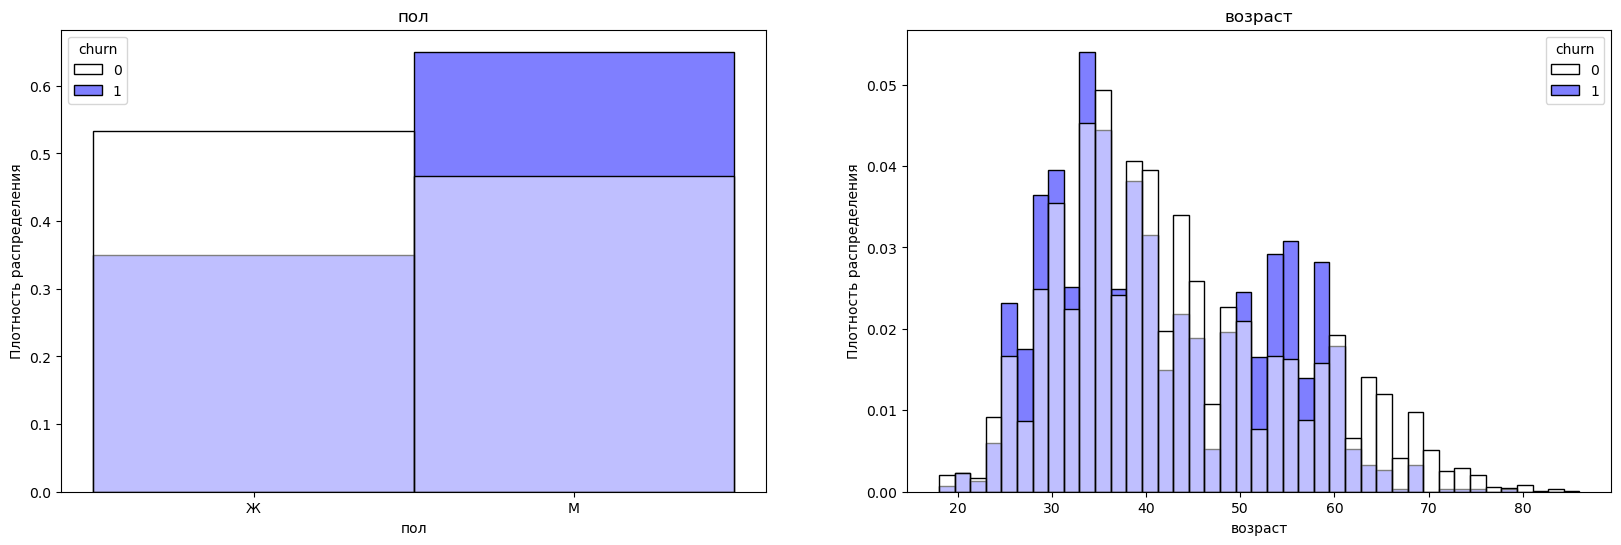

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 строка, 2 столбца
ax1, ax2 = axes  # Распаковка осей

sns.histplot(data=data, hue = 'churn', x = 'gender', stat = 'density', common_norm = False, discrete=True, ax=ax1, palette = 'flag' )
ax1.set_title('пол')
ax1.set_xlabel('пол', fontsize=10)
ax1.set_ylabel('Плотность распределения')

sns.histplot(data=data, hue = 'churn', x = 'age', stat = 'density', common_norm = False, ax=ax2, palette = 'flag' )
ax2.set_title('возраст')
ax2.set_xlabel('возраст', fontsize=10)
ax2.set_ylabel('Плотность распределения')

plt.show()

Среди мужчин доля отток как видно больше чем у женщин, при то что распределение клентов по полу примерно одинаковое.

В группе отток клиентов в возррасте 26-34 лет и у старшего поколения в диапазоне 50-60 лет. В групе оставшиеся клиенты возрастном диапазоне 18-25 лет, 35-49, 61+. Линеная зависимость отстутсвует


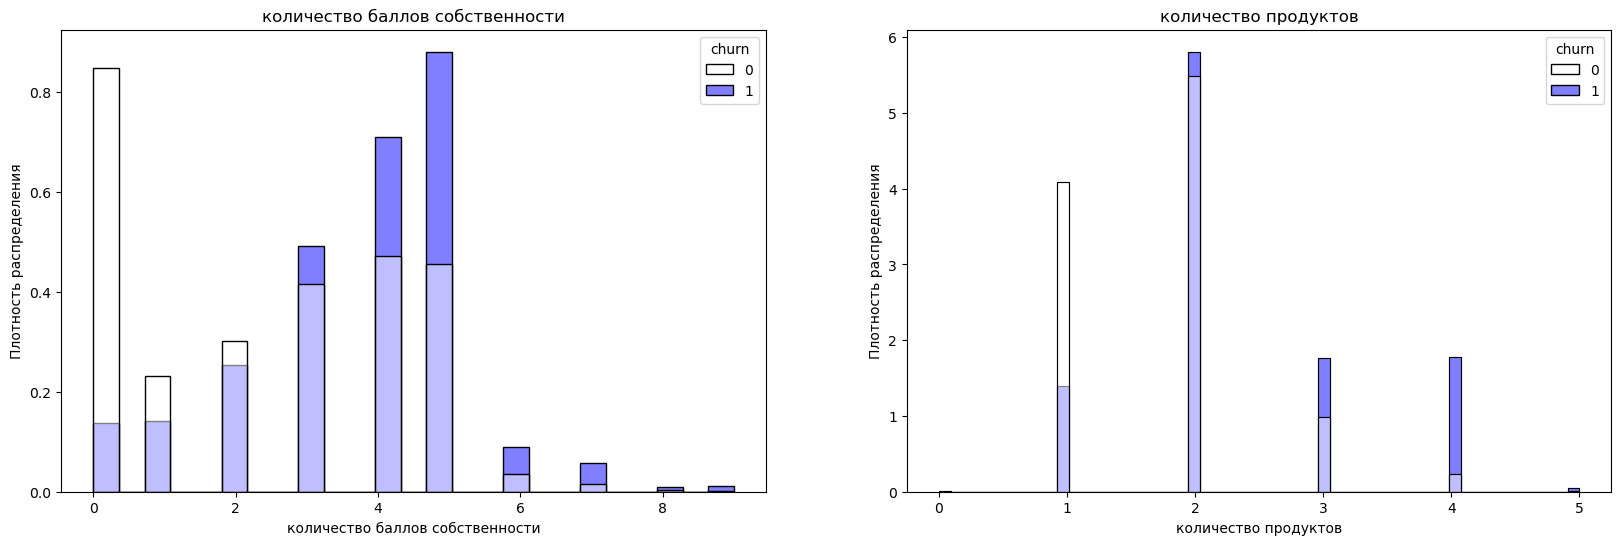

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 строка, 2 столбца
ax1, ax2 = axes  # Распаковка осей

sns.histplot(data=data, hue = 'churn', x = 'equity', stat = 'density', common_norm = False, ax=ax1, palette = 'flag' )
ax1.set_title('количество баллов собственности')
ax1.set_xlabel('количество баллов собственности', fontsize=10)
ax1.set_ylabel('Плотность распределения')

sns.histplot(data=data, hue = 'churn', x = 'products', stat = 'density', common_norm = False, ax=ax2, palette = 'flag' )
ax2.set_title('количество продуктов')
ax2.set_xlabel('количество продуктов', fontsize=10)
ax2.set_ylabel('Плотность распределения')

plt.show()

Самый значительный отток клиентов имеющиют 5 баллов собственности. В группе оставшиеся напротив наибольшее количество клиентов не имеют баллов собственности. 

В группе отток наибольшее количество клиентов имеют 2 банковских продукта, при этом доля уходящих клиентов с ростом количества используемых продуктов растет. Возможно уходящих клиентов не устраивают существующие банковский продукты и они находятся в поиске лучших вариантов и находят их в других банках.
В группе оставшиеся наибльшее количество клиентов таже имеют 2 банковских продукта. Примечатльно, что клиенты с 1 банковским продуктом(на пример зарплатная карта) чаще остаются клиентами банка.


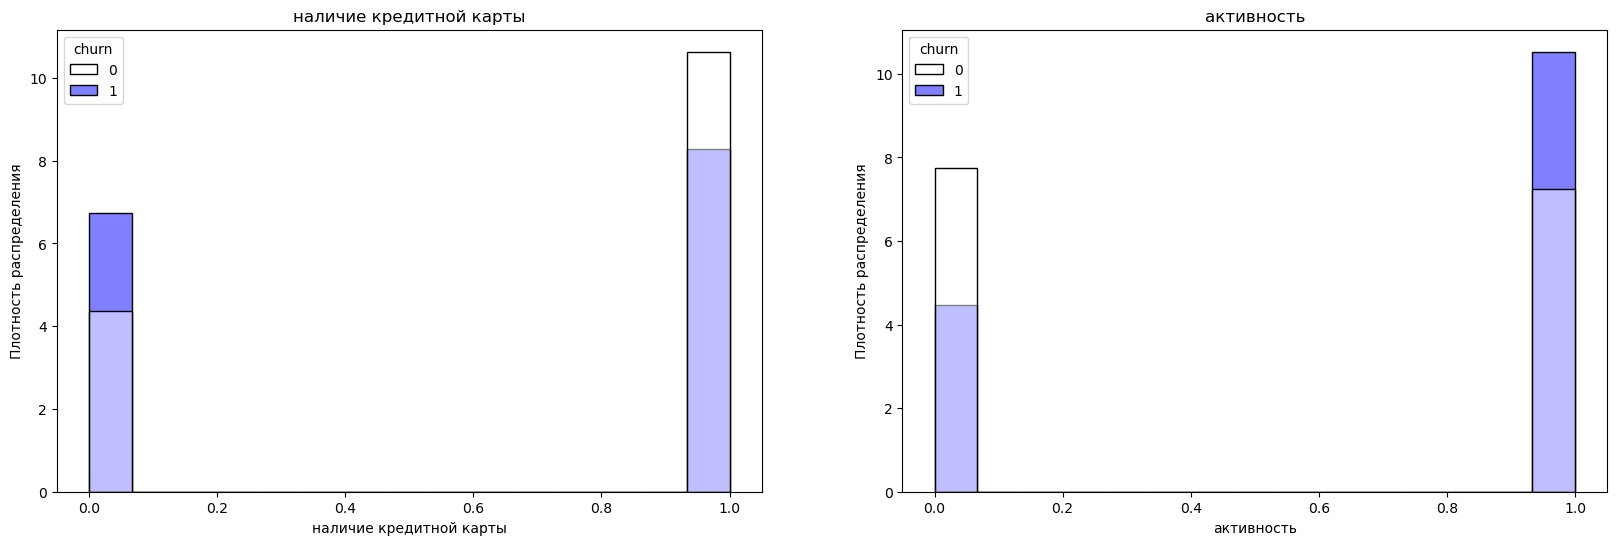

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 строка, 2 столбца
ax1, ax2 = axes  # Распаковка осей

sns.histplot(data=data, hue = 'churn', x = 'credit_card', stat = 'density', common_norm = False, ax=ax1, palette = 'flag' )
ax1.set_title('наличие кредитной карты')
ax1.set_xlabel('наличие кредитной карты', fontsize=10)
ax1.set_ylabel('Плотность распределения')

sns.histplot(data=data, hue = 'churn', x = 'last_activity', stat = 'density', common_norm = False, ax=ax2, palette = 'flag' )
ax2.set_title('активность')
ax2.set_xlabel('активность', fontsize=10)
ax2.set_ylabel('Плотность распределения')

plt.show()

Наличие кредитной карты у клиента добавляет лояльности к банку и тем самым снижает долю оттока по сравнению с клиентами которые кредитной карты не имеют.

Активные клиенты чаще менее лояльны к банку и чаще попадают в группу отток, тогда как неактивные клиенты остаются в банке

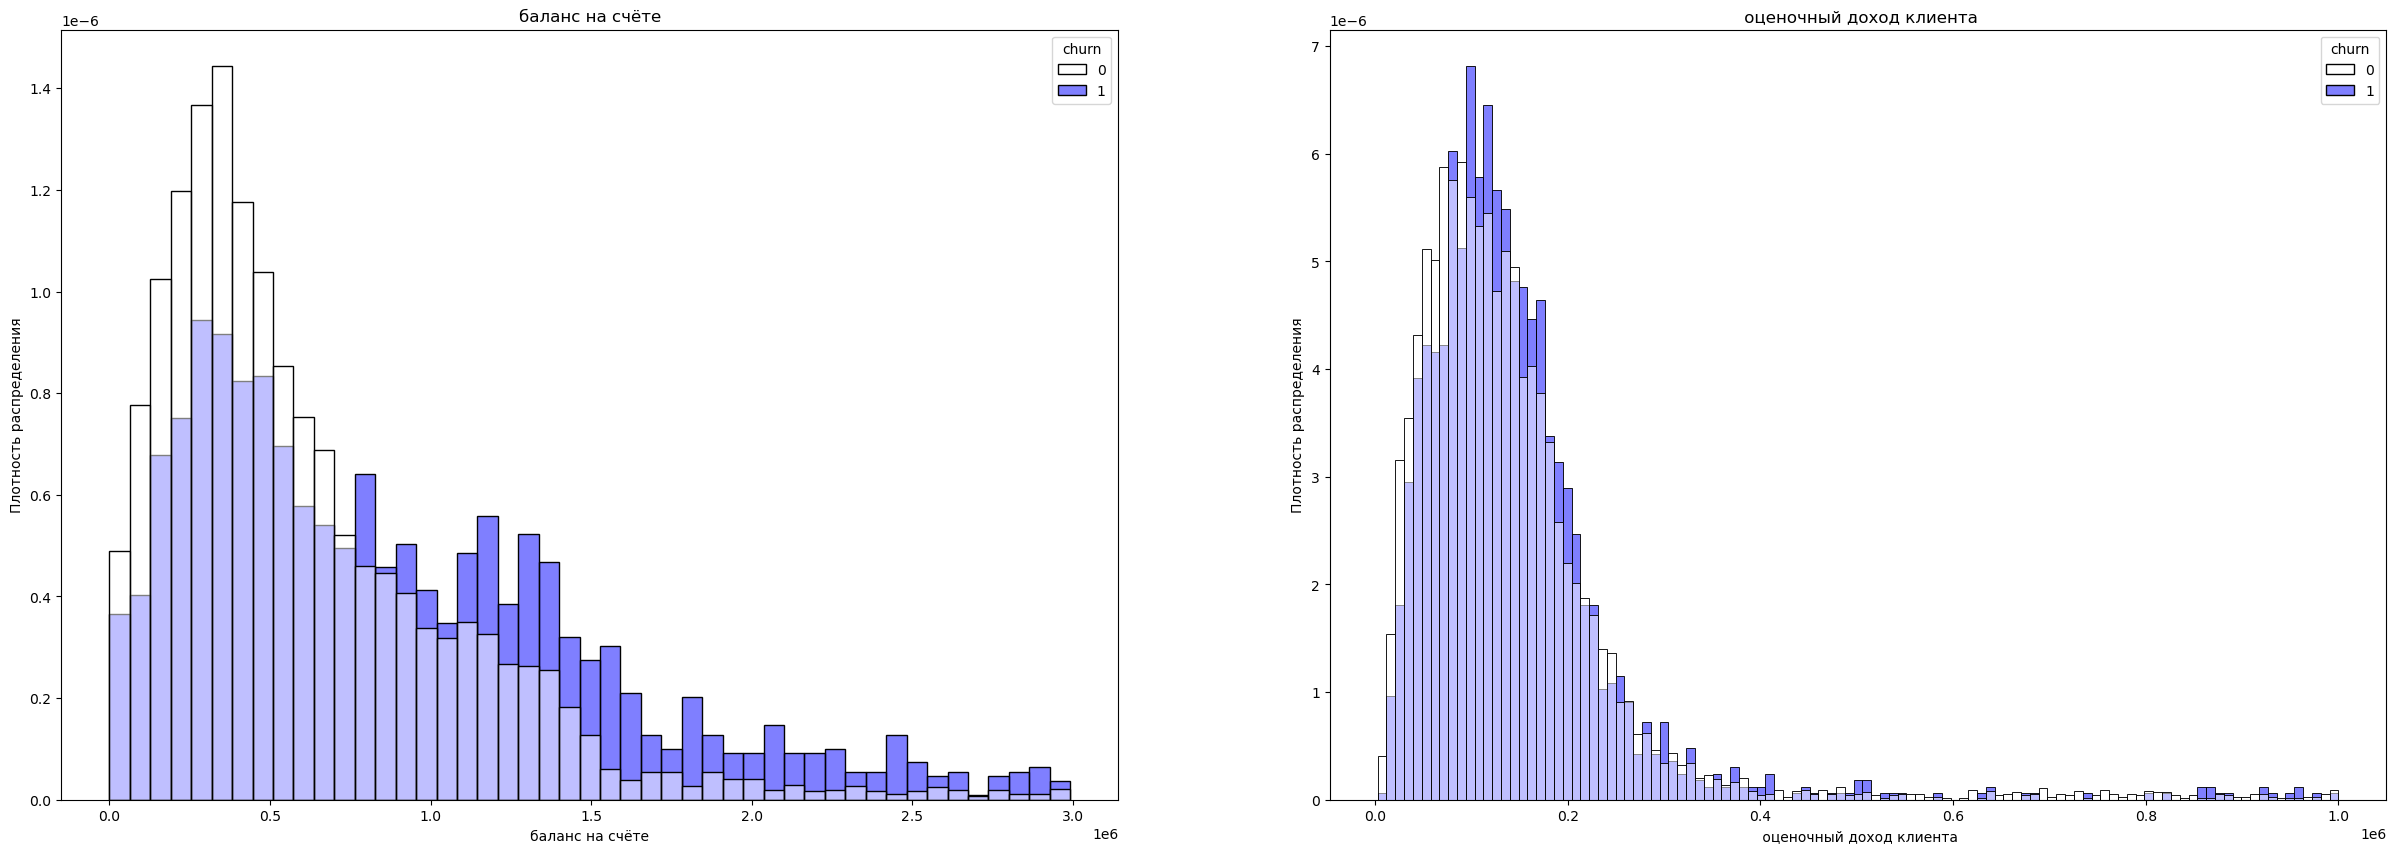

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))  # 1 строка, 2 столбца
ax1, ax2 = axes  # Распаковка осей

sns.histplot(data=data.query('balance <= 3000000'), hue = 'churn', x = 'balance', stat = 'density', common_norm = False, ax=ax1, palette = 'flag' )
ax1.set_title('баланс на счёте')
ax1.set_xlabel('баланс на счёте')
ax1.set_ylabel('Плотность распределения')

sns.histplot(data=data.query('est_salary <= 1000000'), hue = 'churn', x = 'est_salary', stat = 'density', common_norm = False, ax=ax2, palette = 'flag' )
ax2.set_title(' оценочный доход клиента')
ax2.set_xlabel(' оценочный доход клиента')
ax2.set_ylabel('Плотность распределения')

plt.show()

Постоим менее детальный график для лучшег физуального восприятия границ

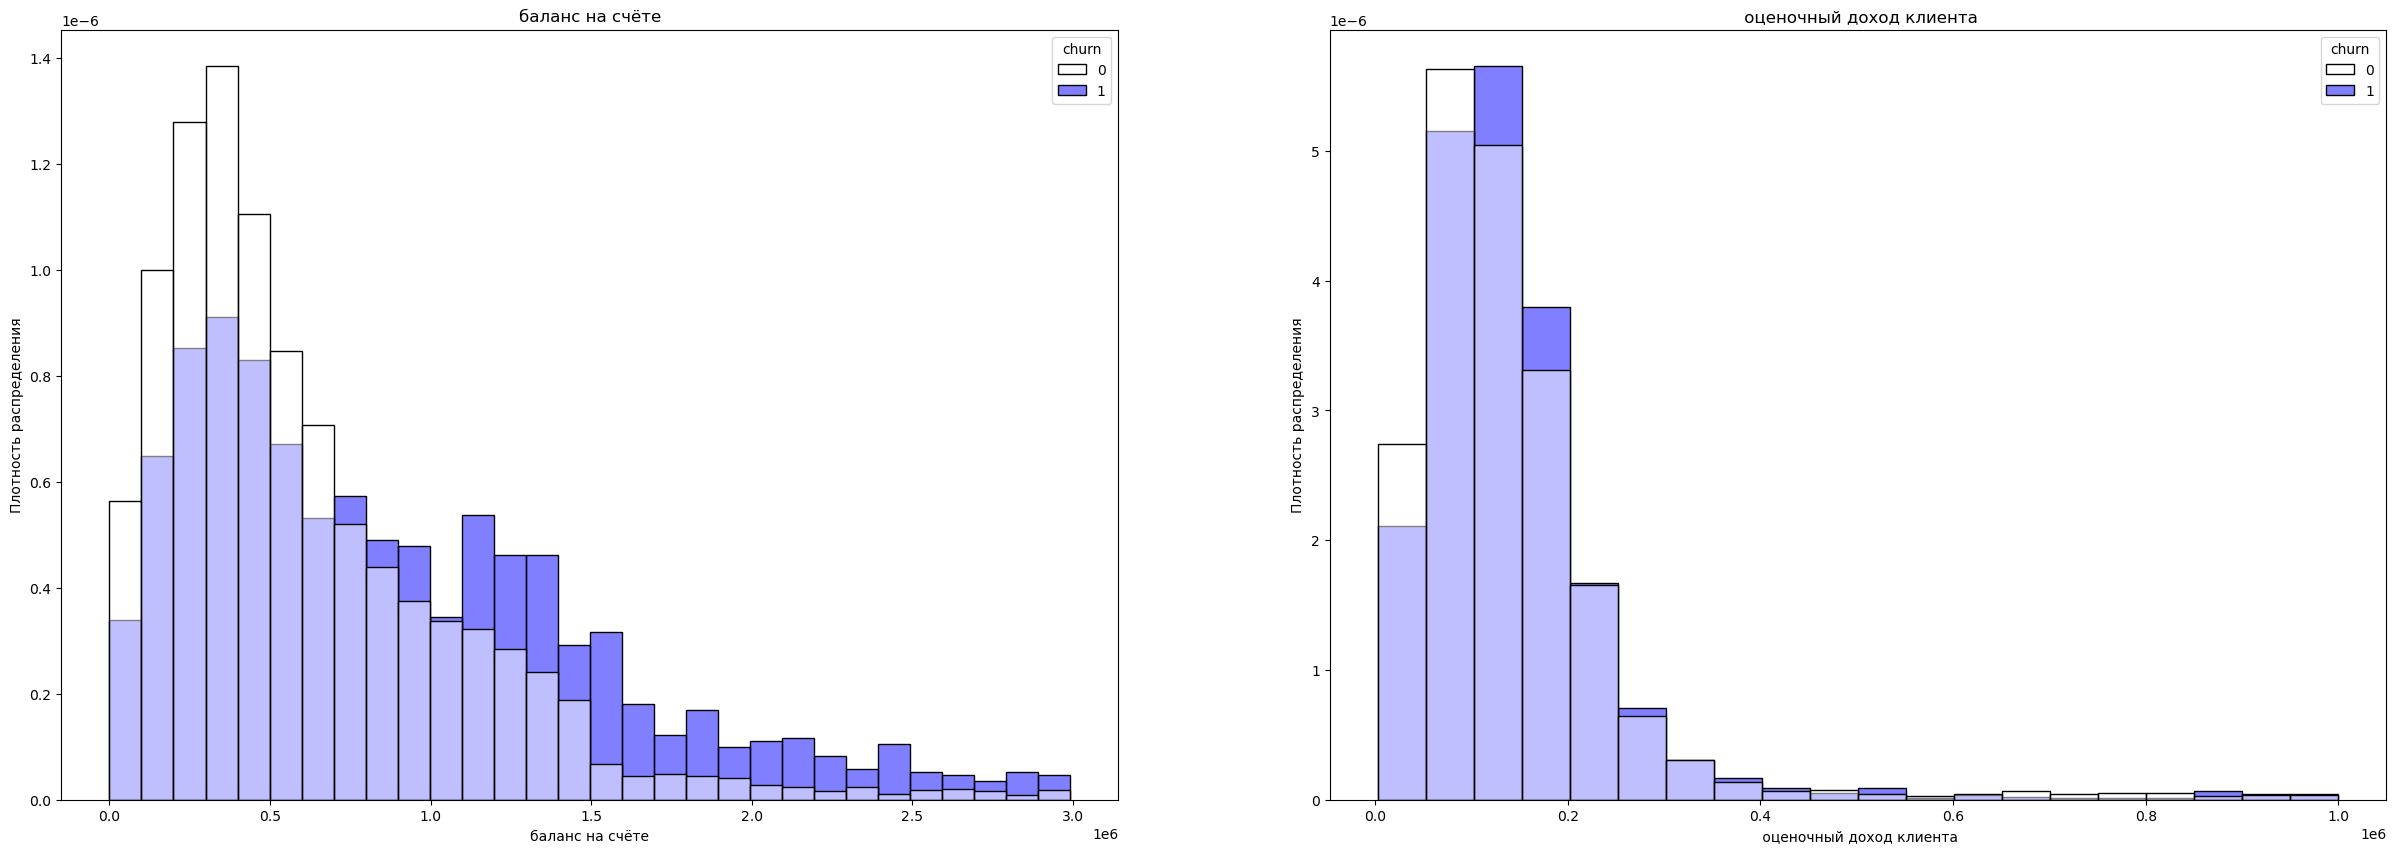

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))  # 1 строка, 2 столбца
ax1, ax2 = axes  # Распаковка осей

sns.histplot(data=data.query('balance <= 3000000'), hue = 'churn', x = 'balance', stat = 'density', common_norm = False, ax=ax1, binwidth=100000, palette = 'flag' )
ax1.set_title('баланс на счёте')
ax1.set_xlabel('баланс на счёте')
ax1.set_ylabel('Плотность распределения')

sns.histplot(data=data.query('est_salary <= 1000000'), hue = 'churn', x = 'est_salary', stat = 'density', common_norm = False, ax=ax2, binwidth=50000, palette = 'flag' )
ax2.set_title(' оценочный доход клиента')
ax2.set_xlabel(' оценочный доход клиента')
ax2.set_ylabel('Плотность распределения')

plt.show()

С ростом баланса на счете вероятность что клиент покинет банк возрастает. Так примерно с отметки в 700000 вероятность что клиент покинет банк резко возрастает над вероятностью, что останется. При этом такая тенденция наблюдается на всем диапазоне после указанной величины

Аналогичная картина для распределения клиентов по оценочному доходу - отдельно можно отметить доход в раойне 70000, здесь наблюдатеся рост оттока с последующим снижением. Далее с ростом дохода в диапазоне примерно с 100000 до 200000 вероятность оттока превышает веротяность остаться. Далее почти на всем диапазоне картина не однородная, однако далее количетсов клиентов с более высокими доходами значитльно ниже и допустимо выделить всех с дозодом 200000+ в отдельный сегмент

**Типичный портрет клиента группы отток:** это клиенты с довольно высоким баллом кредитного скоринга. Диапазон баллов 830-930. 
Чаще это мужчины. Возрраст 26-34 лет и у старшего поколения в диапазоне 50-60 лет также значительный отток, имеюют 5 баллов собственности, пользуются 2 и более банковскими продуктами, чаще не имеет кредитной карты, это активные клиенты. Имеет доход 100000-200000, баланс счета более 700000. Вероятно имеют определенные тредования к имющимся банковсим продуктам и уходят в другие банки в поисках луших условий и/или сервиса


**Типичный портрет клиента группы оставшиеся:** активные клиенты в возрасте 18-25 лет, 35-49, 61+, чаще это женщины Оставшиеся клиенты имеют кредитную карту, пользуется 1 банковскими продуктом, имеет 0-2 баллов собственности с уменьшением лояльности. Клиенты группы оставшиеся в большинстве своем имеют баллы кредитного скорринга в диапазоне до 830 и 930-1000, неактивные клиенты. Имеют доход до 100000 или больше 200000, баланс счета до 700000

### Матрица корреляции признаков

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.0,0.1,0.1,0.0,0.5,0.2,0.3,0.2,0.1,0.4,0.2
city,0.1,1.0,0.0,0.1,0.1,0.0,0.2,0.1,0.0,0.2,0.0
gender,0.1,0.0,1.0,0.3,0.1,0.1,0.1,0.2,0.0,0.1,0.2
age,0.0,0.1,0.3,1.0,0.1,0.0,0.1,0.2,0.1,0.4,0.2
equity,0.5,0.1,0.1,0.1,1.0,0.0,0.4,0.2,0.1,0.3,0.3
balance,0.2,0.0,0.1,0.0,0.0,1.0,0.0,0.0,0.0,0.4,0.0
products,0.3,0.2,0.1,0.1,0.4,0.0,1.0,0.5,0.2,0.2,0.4
credit_card,0.2,0.1,0.2,0.2,0.2,0.0,0.5,1.0,0.1,0.0,0.2
last_activity,0.1,0.0,0.0,0.1,0.1,0.0,0.2,0.1,1.0,0.0,0.3
est_salary,0.4,0.2,0.1,0.4,0.3,0.4,0.2,0.0,0.0,1.0,0.1


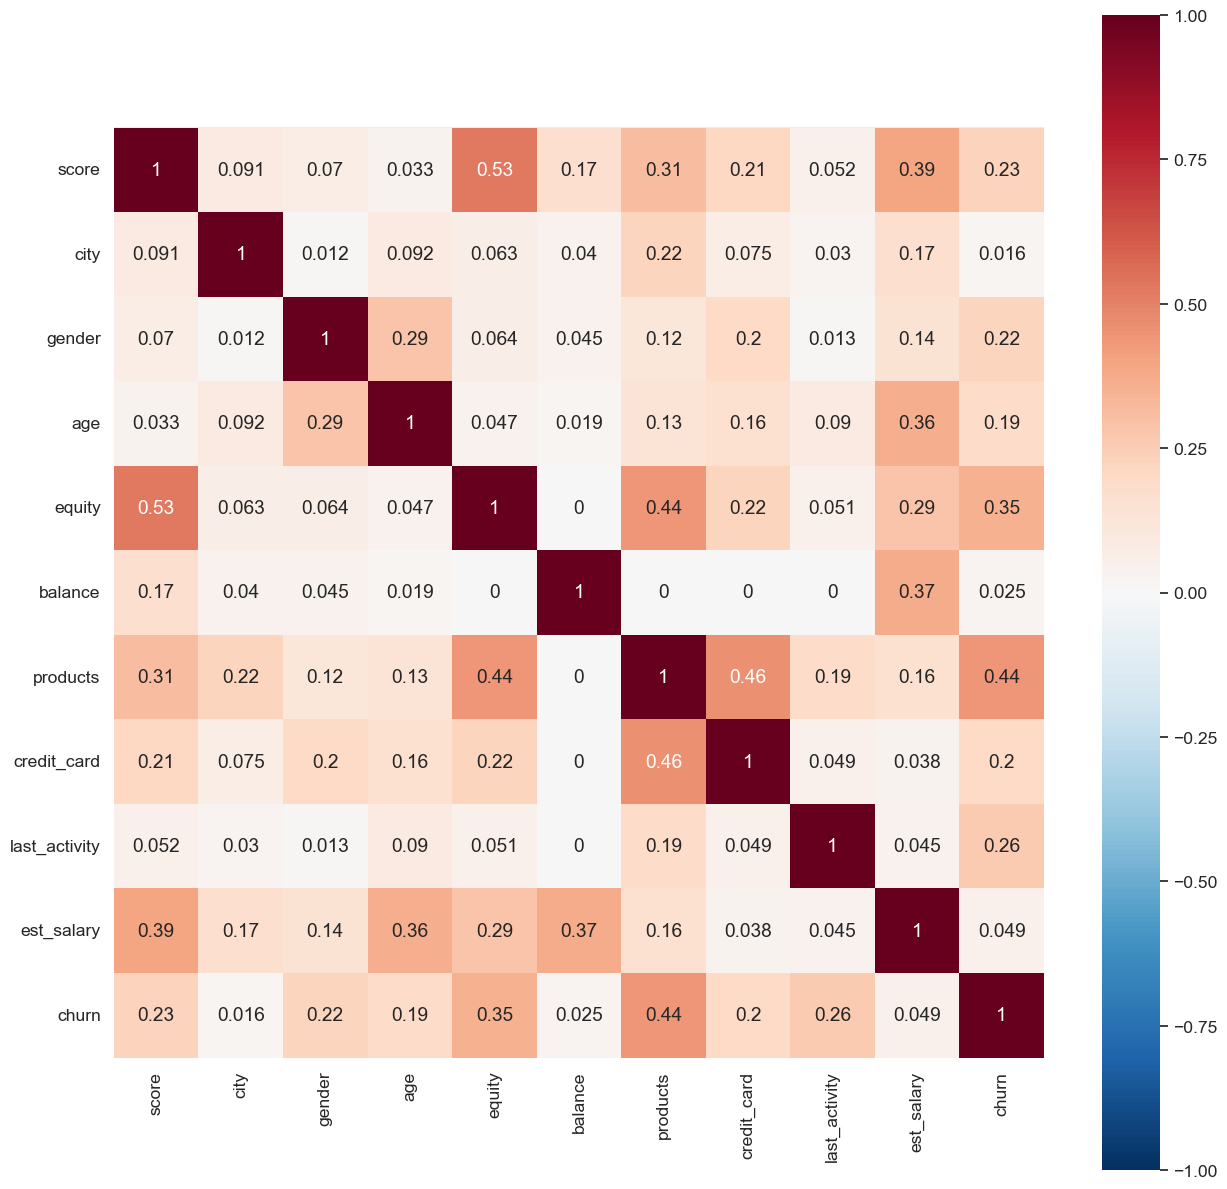

In [69]:
phik_data = data.drop('userid', axis=1).phik_matrix()
display(phik_data.round(2))

sns.set(font_scale=1.15)
figsize = (15,15)


fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(
    phik_data,        
    cmap='RdBu_r', # задаёт цветовую схему
    annot=True, square=True,
    vmin=-1, vmax=1)
plt.show()

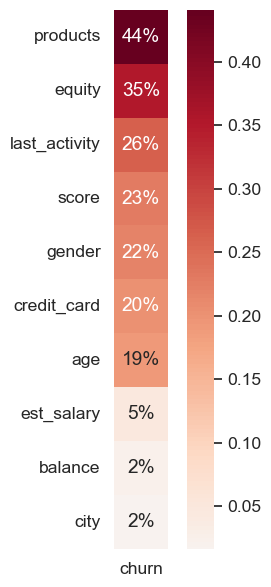

In [73]:
figsize = (5,7)


fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(
    phik_data.loc[:,['churn']].drop('churn').sort_values('churn', ascending = False),
    cmap='RdBu_r', # задаёт цветовую схему
    annot=True, fmt='.0%', square=True, center = 0)
    #vmin=-1, vmax=1)
plt.show()

Как видно, наибольшая корреляця 44% наблюдается с количеством банковских продуктов `products` , котрыми пользуется клиент, чем больше продукто клиент использует тем выше лояльность к выбранному банку, тем ниже вероятность попасть в группу отток

количество баллов собственности `equity`- корреляция 35%, вероятно чем больше баллов тем ниже отток, клиенту важна стабильность, такой клиент менее подвержен к переменнам в т.ч. смены банка

активный клиент `last_activity` 26% корреляция - чем чаще клиент пользуется услугами конкретного банка, тем выше его лояльность, тем меньше вероятность сменить банк

баллы кредитного скоринга `score` - корреляция 23% - чем выше балл тем более вероято клиент может получать кредитные продукты по более лояльной ставке кредита, либо это могут быть дополнительные бонусы, что также положительно скажется на лояльности клиента 

корреляция `gender` пола составляет 22%, в действительность как можно наблюдать на графике, мужчины несколько чаще склонны менять банк, чем женщины 

коррелиция по наличию кредитной карты `credit_card` с оттоком клиентов составляет 20%


`age` возраст также оказывает вляние на вероятность оттока клиентов, корреляция составляет 19%

Влияние таких параметров как оценочный доход, баланс счет и город незначительно влияют на вероятность оттока

## Сегментация клиентов

Наиболее весомыми с точки зрения корреляции с параметром отток/оставшиеся можно выделить 5 параметров: products, equity, last_activity, score, gender

Выделим сегменты:

    1. Мужчины, возраст 25-34 или 50-60 лет, доход до 100000
    2. Клиенты с баллом кредитного скоринга 830-930, количество продуктов 2+, возраст 35-49 лет
    3. Активные клиенты количество баллов собственности 3+, баланс менее 700000
    4. Неактивные клиенты баланс более 700000, доход от 100000 до 200000

In [79]:
#1 М возраст 26-34 или 50-60 доход до 100тр
display(data.query('gender == "М" & age > 25 & age <=34 | age >50 & age <=60 & est_salary < 100000 & products < 2')['churn'].agg(['count', 'mean']))

#2 кредитны скоринг 830-930 2+ продукт возраст 35-49 лет
display(data.query('score >= 830 & score < 930 & products >= 2 & age > 34 & age <=49')['churn'].agg(['count', 'mean']))

#3 активный баллы собственности 3+
display(data.query('last_activity == 1 & equity >= 3 & balance < 700000')['churn'].agg(['count', 'mean']))

#4 активный баллы собственности 3+
display(data.query('last_activity == 1 & equity >= 3 & balance > 700000')['churn'].agg(['count', 'mean']))

count   1641.0
mean       0.3
Name: churn, dtype: float64

count   1358.0
mean       0.3
Name: churn, dtype: float64

count   1534.0
mean       0.3
Name: churn, dtype: float64

count   1386.0
mean       0.5
Name: churn, dtype: float64

In [81]:
#### собираем сегменты по высокоотточным границам


#1 М возраст 26-34 или 50-60 доход 100тр-200тр
display(data.query('gender == "М" & age > 25 & age <=34 | age >50 & age <=60 & est_salary > 100000 & est_salary < 200000')['churn'].agg(['count', 'mean']))

#1 М возраст 26-34 или 50-60 доход 100тр-200тр
display(data.query('gender == "М" & age > 34 & age <=49 & est_salary > 200000 & est_salary < 200000')['churn'].agg(['count', 'mean']))



#2 кредитны скоринг 830-930 0-1 продукт возраст 35-49 лет
display(data.query('score >= 830 & score < 930 & products < 2')['churn'].agg(['count', 'mean']))

#2 кредитны скоринг 830-930 2+ продукт возраст 35-49 лет
display(data.query('score >= 830 & score < 930 & products >= 2 & age > 34 & age <=49')['churn'].agg(['count', 'mean']))



#4 активный баллы собственности 3+
display(data.query('last_activity == 1 & equity >= 3 & balance < 700000')['churn'].agg(['count', 'mean']))

#4 активный баллы собственности 3+
display(data.query('last_activity == 1 & equity >= 3 & balance > 700000')['churn'].agg(['count', 'mean']))


count   2105.0
mean       0.3
Name: churn, dtype: float64

count   0.0
mean    NaN
Name: churn, dtype: float64

count   1743.0
mean       0.1
Name: churn, dtype: float64

count   1358.0
mean       0.3
Name: churn, dtype: float64

count   1534.0
mean       0.3
Name: churn, dtype: float64

count   1386.0
mean       0.5
Name: churn, dtype: float64

churn
0    1390
1     469
Name: userid, dtype: int64

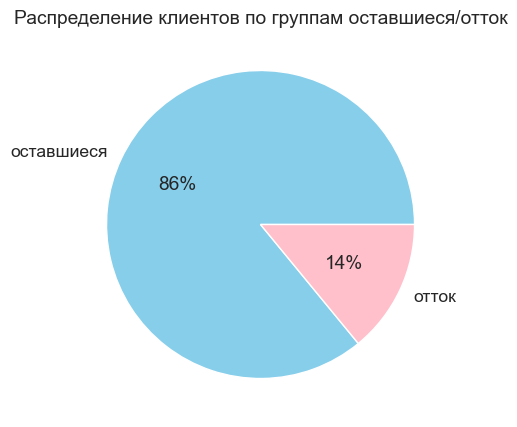

In [82]:
# Распределение клиентов по группам оставшиеся/отток
custom_labels = ['оставшиеся', 'отток']
colors = ['skyblue', 'pink']

display(data.query('gender == "М" & last_activity == 1  & credit_card == 1').groupby('churn')['userid'].count())

data.query('gender == "М" & last_activity == 0  & credit_card == 1').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(5,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')



plt.subplots_adjust(hspace=0.5)
plt.show()

churn
0    1560
1     499
Name: userid, dtype: int64

churn
0    1458
1     446
Name: userid, dtype: int64

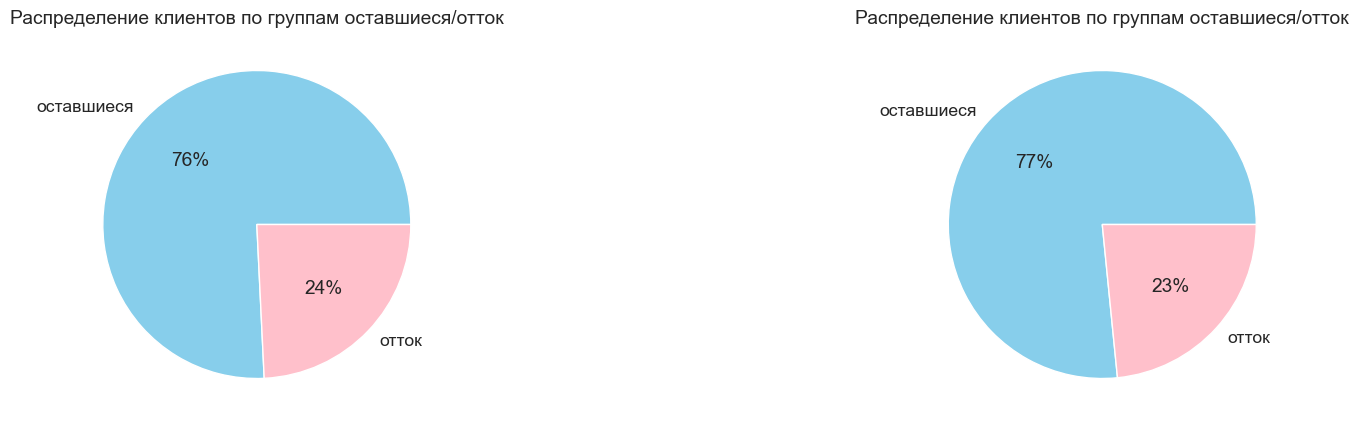

In [83]:
# 1 сегмент мужчины с низким кредитным рейтингом, потенциально отточного возраста 26-34 и 50-60 лет

custom_labels = ['оставшиеся', 'отток']
colors = ['skyblue', 'pink']

display(data.query('gender =="М" & score >= 600 & score < 830 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count())

plt.subplot(1, 2, 1)
data.query('gender =="М" & score >= 600 & score < 830 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(20,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')

# 2 сегмент Женщины с низким кредитным рейтингом, потенциально отточного возраста 26-34 и 50-60 лет
display(data.query('gender =="Ж" & score >= 600 & score < 830 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count())
plt.subplot(1, 2, 2)
data.query('gender =="Ж" & score >= 600 & score < 830 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(20,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')


plt.subplots_adjust(hspace=0.5)
plt.show()

Сегменты Мужчина или Жещина с низким кредитным рейтингом, потенциально отточного возраста 26-34 и 50-60 лет Оба сегмента имеют Отток составляет 24% и 23% соответственно - выше среднего оттока по всей выбрке 18%. Смена полу не влияет. Потенциально проблемный сегмент 

churn
0    1600
1     650
Name: userid, dtype: int64

churn
0    1168
1     432
Name: userid, dtype: int64

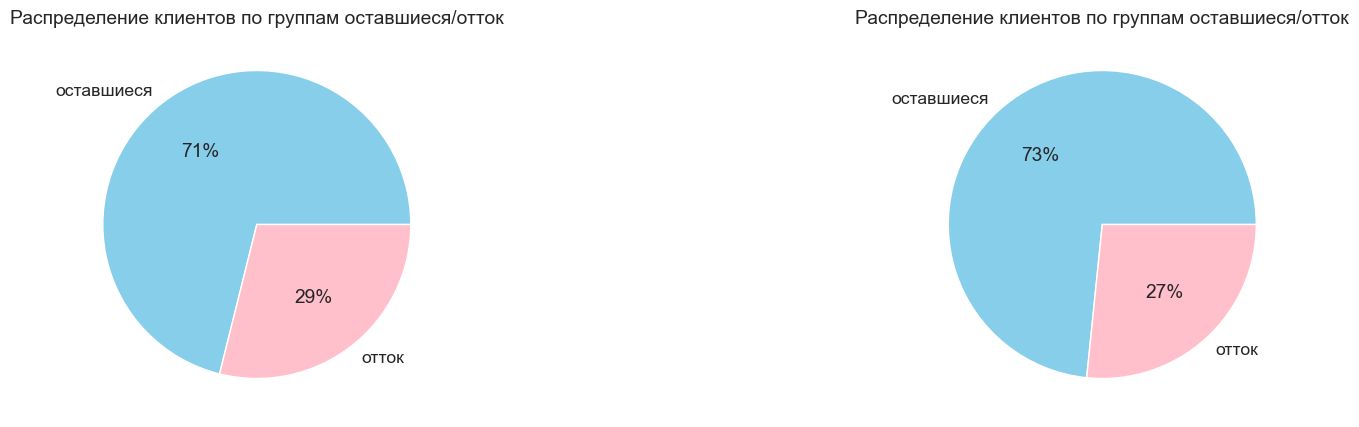

In [85]:
# 1 сегмент мужчины с низким кредитным рейтингом, потенциально отточного возраста 26-34 и 50-60 лет

custom_labels = ['оставшиеся', 'отток']
colors = ['skyblue', 'pink']

display(data.query('gender =="М" & score >= 830 & score < 930 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count())

plt.subplot(1, 2, 1)
data.query('gender =="М" & score >= 830 & score < 930 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(20,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')

# 2 сегмент Женщины с низким кредитным рейтингом, потенциально отточного возраста 26-34 и 50-60 лет
display(data.query('gender =="Ж" & score >= 830 & score < 830 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count())
plt.subplot(1, 2, 2)
data.query('gender =="Ж" & score >= 830 & score < 930 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(20,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')


plt.subplots_adjust(hspace=0.5)
plt.show()

churn
0    1930
1     370
Name: userid, dtype: int64

churn
0    1098
1     103
Name: userid, dtype: int64

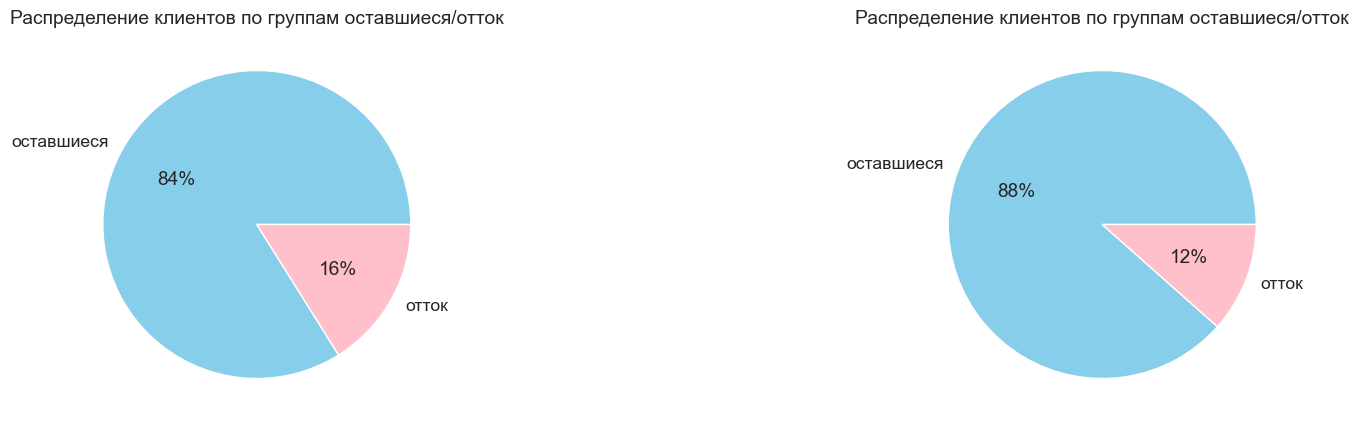

In [86]:
# 1 сегмент мужчины с низким кредитным рейтингом, потенциально отточного возраста 26-34 и 50-60 лет

custom_labels = ['оставшиеся', 'отток']
colors = ['skyblue', 'pink']

display(data.query('gender =="М" & score >= 830 & score < 930 & age >= 35 & age < 49 | age >= 60').groupby('churn')['userid'].count())

plt.subplot(1, 2, 1)
data.query('gender =="М" & score >= 830 & score < 930 & age >= 26 & age >= 35 & age < 49 | age >= 60').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(20,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')

# 2 сегмент Женщины с низким кредитным рейтингом, потенциально отточного возраста 26-34 и 50-60 лет
display(data.query('gender =="Ж" & score >= 830 & score < 830 & age >= 35 & age < 49 | age >= 60').groupby('churn')['userid'].count())
plt.subplot(1, 2, 2)
data.query('gender =="Ж" & score >= 830 & score < 930 & age >= 35 & age < 49 | age >= 60').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(20,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')


plt.subplots_adjust(hspace=0.5)
plt.show()

churn
0    1979
1     779
Name: userid, dtype: int64

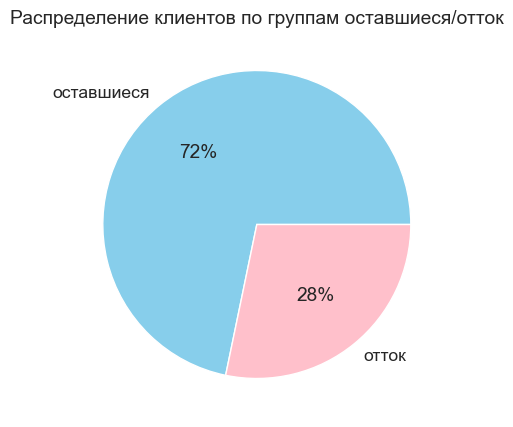

In [87]:
custom_labels = ['оставшиеся', 'отток']
colors = ['skyblue', 'pink']

display(data.query('score >= 830 & score < 930 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count())

data.query('score >= 830 & score < 930 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(5,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')



plt.subplots_adjust(hspace=0.5)
plt.show()

Клиенты в возрасте 26-34 и 50-60 c низким уровнем кедитного скоринга только 22% попадают в отток

churn
0    1242
1     525
Name: userid, dtype: int64

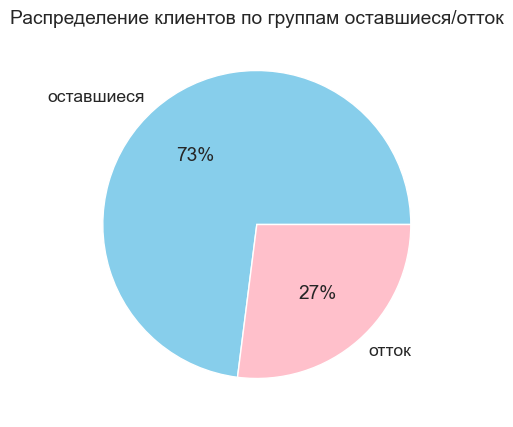

In [89]:
custom_labels = ['оставшиеся', 'отток']
colors = ['skyblue', 'pink']

display(data.query('products > 2 & score >= 830 & score < 930 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count())

data.query('products > 2 & score >= 830 & score < 830 & age >= 26 & age < 34 | age >= 50 & age < 60').groupby('churn')['userid'].count().plot(kind = 'pie', figsize=(5,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')



plt.subplots_adjust(hspace=0.5)
plt.show()

In [90]:
display(data.query('products <=1 & equity >3').groupby('churn')['userid'].count())

churn
0    519
1    111
Name: userid, dtype: int64

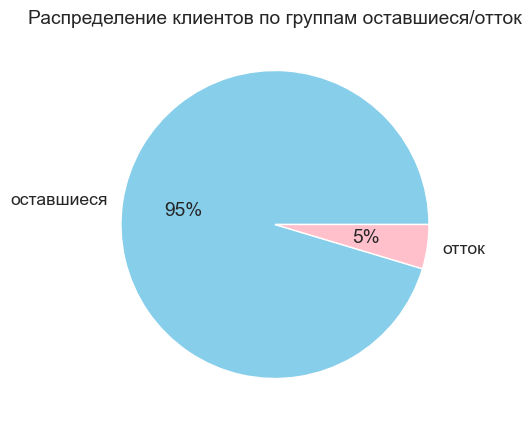

In [91]:
custom_labels = ['оставшиеся', 'отток']
colors = ['skyblue', 'pink']
data.query('products <=1 & equity <=3').groupby('churn')['userid'].count().sort_values(ascending = False).plot(kind = 'pie', figsize=(5,5), autopct='%1.0f%%', labels=custom_labels,legend = False, colors=colors)
plt.title('Распределение клиентов по группам оставшиеся/отток')
plt.ylabel('')



plt.subplots_adjust(hspace=0.5)
plt.show()

### Сегментация по параметру `products` количество продуктов

C:\Users\Vitte\AppData\Local\Temp\ipykernel_10308\2997343829.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  display(data.pivot_table(index='products_group', values = 'churn', aggfunc = ('count','mean')))


,count,mean
products_group,,
0-1,3324,0.1
2-5,6631,0.2


C:\Users\Vitte\AppData\Local\Temp\ipykernel_10308\2997343829.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data.pivot_table(index='products_group', values = 'churn', aggfunc = ('mean')).plot(kind='bar',color='skyblue', legend = False)


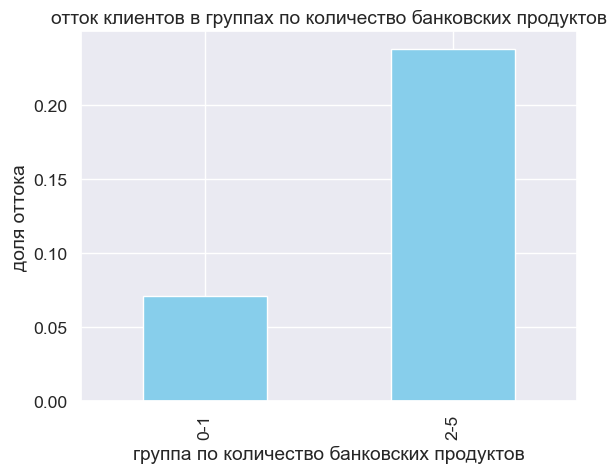

In [93]:

bins = [0, 2, 5]
labels = ['0-1', '2-5']

data['products_group'] = pd.cut(data['products'], bins=bins, labels=labels, right=False)


display(data.pivot_table(index='products_group', values = 'churn', aggfunc = ('count','mean')))

data.pivot_table(index='products_group', values = 'churn', aggfunc = ('mean')).plot(kind='bar',color='skyblue', legend = False)
plt.title('отток клиентов в группах по количество банковских продуктов')
plt.xlabel('группа по количество банковских продуктов')
plt.ylabel('доля оттока')
plt.show()


В сегментации клиентов по наличию продуктов выделим 2 сегмента: в группе отток приемущество клиенты пользуютя 2-5 продуктами - отток составляет более 20%, в группе оставшиеся количество продуктов 0-1 и отток менее 10%

,count,mean
products,,
0,1,1.0
1,3323,0.1
2,5119,0.2
3,1038,0.3
4,474,0.6
5,19,0.4


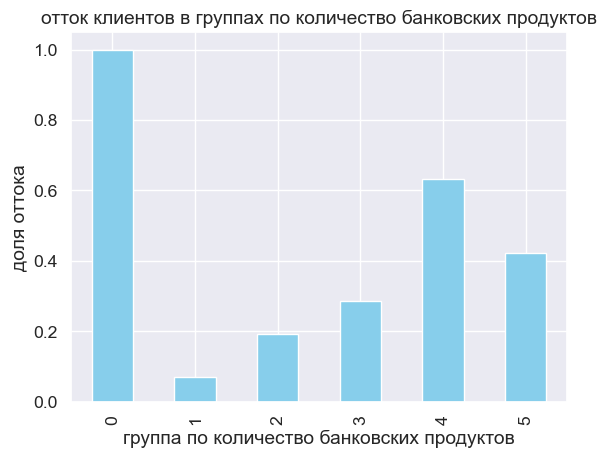

In [95]:
display(data.pivot_table(index='products', values='churn', aggfunc = ('count','mean')).sort_values(by= 'products', ascending=True))

data.pivot_table(index='products', values='churn', aggfunc = ('mean')).sort_values(by= 'products', ascending=True).plot(kind='bar',color='skyblue', legend = False)
plt.title('отток клиентов в группах по количество банковских продуктов')
plt.xlabel('группа по количество банковских продуктов')
plt.ylabel('доля оттока')
plt.show()

В результате сегментации клиентов по количеству продуктов заметно, что в группах с количеством продуктов 1-4 растет доля оттока. Так же следует отметить, что в этих группах сконцентрирована основная доля клиентов банка. Количество клиентов в группах 1 продукт - 3323, 2 продукта - 5119 (самая многоисленная), 3 продукта -1038, 4 продукта - 474. Как правило 1 банковский продукт - это либо зарплатная карта или вклад или счет, что не предполагает ограниченное оиспользования сопуствтующих сервисов банка, но как только количество продуктов увеличивается, то и необходимость испольования сервисов связаннях с этими продуктами также возрастает. 

Таким образом рост оттока с ростом использования продуктов банка может быть связано с неудобством использования продуктов, низкое качество сервиса, навязывание банковских продуктов, не отвечающих действительным потребностям клиентов, это может быть подключение банковских продуктов, которые подлючали как бесплатную опцию, а с течнием времени банк стал брать комиссию за использование и другие причины связанные с качестом сервиса, обслуживания и непосредственно продутом. 

В группе с 0 продуктов и 1 клиентом отток 100%, но размер группы не позволяет сделать выводов о причинах отток ввиду своей незначительности. 

В группе с 5 продуктами наблюдатеся снижение отток по сравнени. группой 4 продукта. Вероятно это "старые" клиенты, глубоко интегрированные в экосистему банка, либо это менеджмент и/или сотрудники банка, которых "положение обязывает" использовать все продукты своего банка.

### Сегментация по параметру `equity` количество баллов собственности

C:\Users\Vitte\AppData\Local\Temp\ipykernel_10308\3664176617.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  display(data.pivot_table(index='equity_group', values = 'churn', aggfunc = ('count','mean')))


,count,mean
equity_group,,
0-2,3349,0.1
3-9,6612,0.2


C:\Users\Vitte\AppData\Local\Temp\ipykernel_10308\3664176617.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data.pivot_table(index='equity_group', values = 'churn', aggfunc = ('mean')).plot(kind='bar',color='skyblue', legend = False)


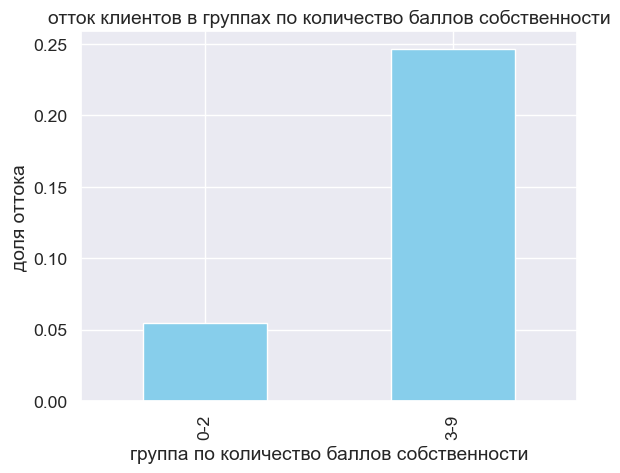

In [98]:

bins = [0, 2, 9]
labels = ['0-2', '3-9']

data['equity_group'] = pd.cut(data['equity'], bins=bins, labels=labels, right=False)


display(data.pivot_table(index='equity_group', values = 'churn', aggfunc = ('count','mean')))

data.pivot_table(index='equity_group', values = 'churn', aggfunc = ('mean')).plot(kind='bar',color='skyblue', legend = False)
plt.title('отток клиентов в группах по количество баллов собственности')
plt.xlabel('группа по количество баллов собственности')
plt.ylabel('доля оттока')
plt.show()

,count,mean
equity,,
0,2576,0.0
1,773,0.1
2,1051,0.2
3,1541,0.2
4,1847,0.3
5,1915,0.3
6,161,0.4
7,80,0.5
8,17,0.4


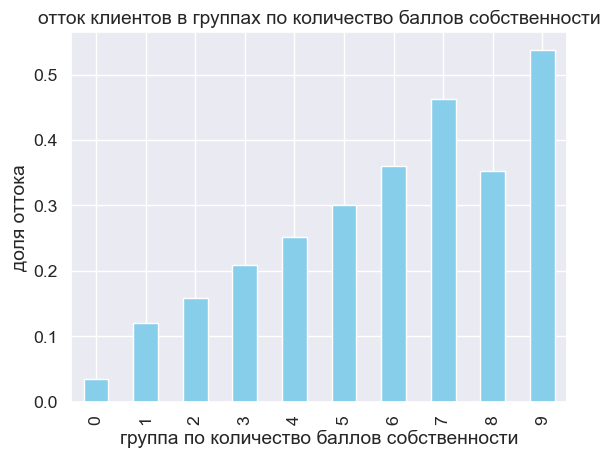

In [99]:
display(data.pivot_table(index='equity', values='churn', aggfunc = ('count','mean')).sort_values(by= 'equity', ascending=True))

data.pivot_table(index='equity', values='churn', aggfunc = ('mean')).sort_values(by= 'equity', ascending=True).plot(kind='bar',color='skyblue', legend = False)
plt.title('отток клиентов в группах по количество баллов собственности')
plt.xlabel('группа по количество баллов собственности')
plt.ylabel('доля оттока')
plt.show()

Сегментация клиентов по количеству баллов собственности в основном показывает линейную зависмость между ростом количеством баллов собственности и ростом доли оттока. 

Группа с количеством баллов 0 составляет 2576 клиентов. Отток в этой группе 0. Такие клиенты могут быть не притязательны к условиям обслуивания сервиса ввиду, того что они только начинают взаимодействовать с банком как самостоятельные агенты (на пример студенты или клиенты в самом начале трудовой деятельности) так и необеспеченные клиенты получающие в этом банке субсидии, господдержку и т.п.

Группы с 2-3 и 3-4 баллами собственности имеют отток 20% и 30% соответственно. Эти группы клиентов в совокупаности формируют соновную массу клиентов банка 6354. Клиенты этих грпп уже имеют какую-то собственность, скорее всего активно взаимодействуют с банком и соответствующими сервисами. Как правло с ростом благосостаяния растут и требования к качеству сервиса и услуг, скорости взаимодействия с банком и его экостистемой.

Группы с 6-9 баллами собственности составляют 271 клиент. Отток в этих группах 40-50% Эти клиенты имеют значительное количество баллов собственности, повышенне требуовани к сервису. Возможно это сегмент претендующий на premium-обслуживания и не получая соответствующего отношения к себе и своим потребностям покидает банк в поисках лучшего сервиса.

### Сегментация по параметру last_activity активный клиент

last_activity
1   0.2
0   0.1
Name: churn, dtype: float64

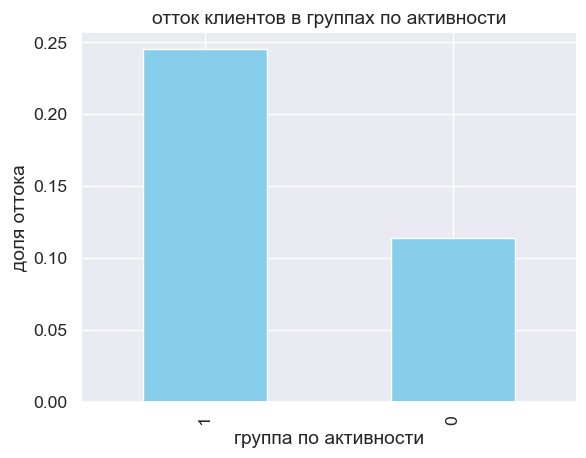

In [102]:
display(data.groupby('last_activity')['churn'].mean().sort_values(ascending=False))
data.groupby('last_activity')['churn'].mean().sort_values(ascending=False).plot(kind='bar',color='skyblue', legend = False)
plt.title('отток клиентов в группах по активности')
plt.xlabel('группа по активности')
plt.ylabel('доля оттока')
plt.show()

Активные клиенты покидают банк в 20% случаев, тогда как неактивные клиенты имеют долю оттока только 10%. Этом может быть напрямую связано с качеством взаимодействия с банком, его уровнем сервиса и услуг

### Сегментация по параметру `score` баллы кредитного скоринга

Сегментацию по параметру score проведем на основании экспертной оценки границ сегментов. При анализе распределения клиентов по группам оставшиеся и отток было выявлено, что клиенты с количестовм баллов кредитног скоринга в диапазоне 850-910 имеют значительный отток. В качестве нижней границы  диапазон 0-769, гриницы 2й группы 770-849 ограниченный начальным значением группы сотавшиеся и начальным значением группы отток. 3я группа 850-909 границы диапазона наиболее многочисленной группы отток. 4я группа все клиенты с баллами скоринга больше 910  

In [106]:

bins = [0, 810, 930, 1000]
labels = ['0-829', '830-929', '930+']

data['score_group'] = pd.cut(data['score'], bins=bins, labels=labels, right=False)


display(data.pivot_table(index='score_group', values = 'churn', aggfunc = ('count','mean')))

C:\Users\Vitte\AppData\Local\Temp\ipykernel_10308\3992888005.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  display(data.pivot_table(index='score_group', values = 'churn', aggfunc = ('count','mean')))


,count,mean
score_group,,
0-829,2868,0.1
830-929,6175,0.2
930+,925,0.2


Анализ распределения и доли оттока по баллам кредитного скоринга показал что по первый 2 сегмента , а это 2868 клиента с диапазоном баллов кредитного скоринга до 850 имеют отток 10%, тогда как клиенты с высоким баллом кредитного скоринга 850-909 и 910+ имеют отток 20%. А это 7100 клиентов. Вероятно, клиенты имеюющие высокий уровень надежности с точки зрения кредитных рисков переманиваются в другие банки за счет лучших условий по кредитным программам. С ростом баллов кредитного скоринга растет доля оттока.

### Сегментация по возрасту

В качестве критериев определения сегментов по возррасту используем станлартные диапазоны '18-29', '30-49', '50-64', '65+'

оставшихся 18-25, 35-49 и 61+, для группы отток диапазон 26-34 и 50-60

In [111]:

bins = [18, 25, 35, 50, 60, 120]
labels = ['18-25', '26-34', '34-49', '50-60', '60+']

#bins = [18, 30, 40, 50, 65, 100]
#labels = ['18-29', '30-39', '40-49', '50-64', '65+']

data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)


display(data.pivot_table(index='age_group', values = 'churn', aggfunc = ('count','mean')))


C:\Users\Vitte\AppData\Local\Temp\ipykernel_10308\684941564.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  display(data.pivot_table(index='age_group', values = 'churn', aggfunc = ('count','mean')))


,count,mean
age_group,,
18-25,236,0.1
26-34,2667,0.2
34-49,4270,0.2
50-60,1600,0.3
60+,1201,0.1


Нулевой отток в группе 65+ может быть связан с наиболее консервативным поведением и нежеанием что-то менять или сложностью перехода и привыканию к новому банку. Во всех остальных группа наблюдается отток в 20%.

В ходе исследования обращает на себя внимание рост оттока клиентов по мере увеличения интенсивности взаимодействия клиента с банком и его сервисами. Вероятно существует взаимосвзяь между количеством используемых продуктов, количеством баллов собственности и кредитного рейтинга с токи зорения, что по мере роста благосостояния расчет потребность в использовании банковских продуктов, активностью их использования и соответственно глубина интеграции клиента в экосистему банка, ростом требований к условиям обслуживания, качеству сервисов и банковским продуктам.

### Кросс-сегментация клиентов

Проверим существует ли взаимосвязь в сочетании разных параметров с долей оттока клиентов. Гипотеза: с ростом благосостояния клиентов увеличивается потребность в использовании банковских продуктов, увеличиваются баллы собственности, растет кредитнй рейтинг и соответственно клиент активнее взаимодейтствует с банком, с банковскими сервисами, предъявляет требования к увроню обслуживания

##### Количества продуктов и активность клиенов с долей оттока

Проверим взаимосвязь количества продуктов и активность клиенов с долей оттока. Гипотеза: увеличение количества используемых продуктов влечет за собой увеличение активности клиентов с банком, его сервисами и увеличивается доля оттока.

In [119]:
display(data.groupby(['products', 'last_activity']).agg({'churn':['count', 'mean']})) #.sort_values(by='churn',ascending=False))
#data.groupby(['products', 'last_activity']).agg({'churn':['mean']}).plot(kind = 'bar')

churn     
                       count mean
products last_activity           
0        0                 1  1.0
1        0              1570  0.1
         1              1753  0.1
2        0              2480  0.1
         1              2639  0.3
3        0               606  0.2
         1               432  0.4
4        0               100  0.9
         1               374  0.6
5        0                 2  1.0
         1                17  0.4

Взаимосвязь между количеством банковских продуктов в сочетании с активностью клиента и оттоком есть в группах с 2 и 3 продуктами, а это основная масса клиентов - 6157. Гипотеза что с ростом количества продуктов и увеличением актвность клиента растут доля оттока. Это может быть результатом предъявляемых требования к условиям обслуживания и качеству сервсиса банка и при их низком качестве клиенты покидают банк. Интересный момент по клиентам с 4 и 5 продуктами по доле оттока. Неактивные клиенты очень часто покидают банк. Это может быть результатом недовольства клиент, когда он узнают что у него существуют какие-то банкосвк продукты о которых он незнал, на пример открыт инвестиионный счет или кредитная карта как доплнительный обязательный продукт при открытии базового продукта (зарплатная карта или вклад, а к нему обязательно открывается кредитная или дебетовая карта) 

##### Количество продуктов и баллов собственности с долей оттока

Проверим взаимосвязь количества продуктов и баллов собственности с долей оттока. Гипотеза: увеличение благосостояние клиента влечет за собой потребность в количестве используемых продуктов влечет увеличение баллов собственности, и соответствено необходимость пользоваться банковскими сервисами и увеличивается доля оттока.

count                               mean                    
products     0      1      2     3     4   5    0   1   2   3   4   5
equity                                                               
0          NaN 1959.0  547.0  58.0  12.0 NaN  NaN 0.0 0.1 0.2 0.6 NaN
1          NaN  255.0  432.0  71.0  13.0 2.0  NaN 0.1 0.1 0.2 0.5 0.0
2          NaN  191.0  709.0 117.0  32.0 2.0  NaN 0.1 0.1 0.2 0.7 0.0
3          1.0  288.0  980.0 199.0  70.0 3.0  1.0 0.1 0.2 0.2 0.7 0.3
4          NaN  301.0 1138.0 274.0 129.0 5.0  NaN 0.1 0.2 0.3 0.6 0.4
5          NaN  283.0 1176.0 280.0 169.0 7.0  NaN 0.2 0.3 0.4 0.6 0.7
6          NaN   27.0   80.0  25.0  29.0 NaN  NaN 0.3 0.3 0.4 0.6 NaN
7          NaN   16.0   38.0  10.0  16.0 NaN  NaN 0.3 0.4 0.4 0.7 NaN
8          NaN    2.0   11.0   2.0   2.0 NaN  NaN 0.0 0.3 0.5 1.0 NaN
9          NaN    1.0    8.0   2.0   2.0 NaN  NaN 1.0 0.5 0.5 0.5 NaN

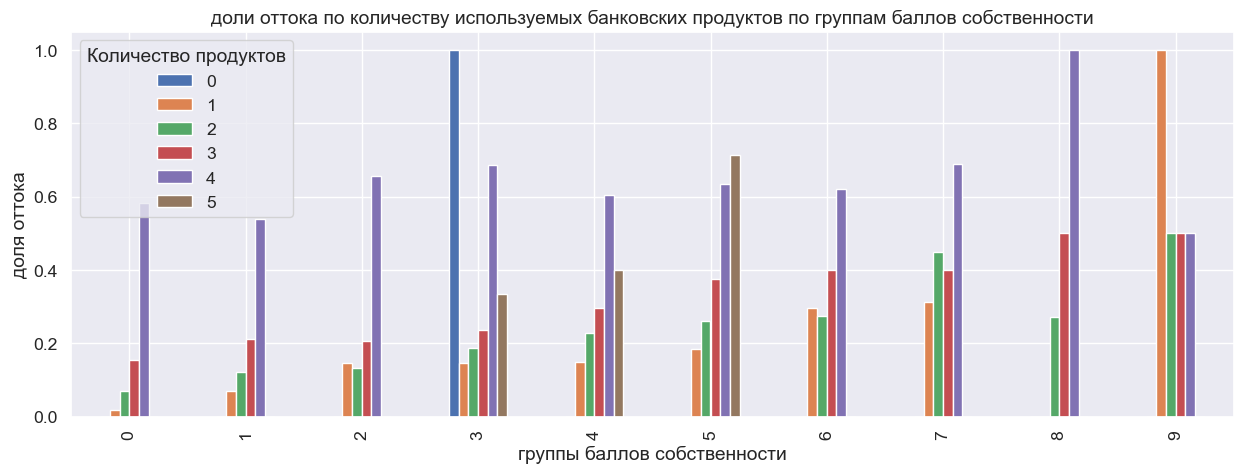

In [123]:
display(data.pivot_table(index = 'equity', columns = 'products', values = 'churn', aggfunc = ('count','mean')))

data.pivot_table(index = 'equity', columns = 'products', values = 'churn', aggfunc = 'mean').plot(kind = 'bar', figsize=(15,5))
plt.title('доли оттока по количеству используемых банковских продуктов по группам баллов собственности')
plt.xlabel('группы баллов собственности')
plt.ylabel('доля оттока')

plt.legend(title='Количество продуктов') 
plt.show()

В большинстве случаев по всем группам баллов собственности имеется тенденция с ростом колиества используемых продуктов увеличиваетс доля оттока. Выделяются группы с 3 и 9 баллами собственности. В них помимо общей тенденции самая высокая доля оттока при наличии 0 или 1 продукта. Это может быть связано с повышенными требования к уровню обслуживания и качеству сервиса на начальном этапе взаимодействия с банком, т.е. при заключении договора на первый банковский продукт и при первоначальном использовании соответственно. Гипотеза в общем имеет право на существование.

##### Количество баллов собственности и баллов кредитноо скоринга с долей отока

Проверим взаимосвязь количества баллов собственности и баллов кредитноо скоринга с долей отока. Гипотеза: приувеличении балогсостаяния ростом баллов собсвтенности растет баллы кредитного кредитного скоринга и отток клиентов 

C:\Users\Vitte\AppData\Local\Temp\ipykernel_10308\1448572683.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  display(data.pivot_table(index = 'equity', columns = 'score_group', values = 'churn', aggfunc = ('count','mean')))


count               mean             
score_group 0-829 830-929 930+ 0-829 830-929 930+
equity                                           
0             750    1413  413   0.0     0.0  0.0
1             348     366   59   0.1     0.1  0.0
2             443     569   39   0.1     0.2  0.1
3             538     920   83   0.1     0.3  0.2
4             453    1257  135   0.1     0.3  0.3
5             301    1440  170   0.1     0.3  0.3
6              26     121   14   0.1     0.4  0.5
7               9      65    6   0.1     0.5  0.8
8               0      14    3   NaN     0.3  0.7
9               0      10    3   NaN     0.4  1.0

C:\Users\Vitte\AppData\Local\Temp\ipykernel_10308\1448572683.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data.pivot_table(index = 'equity', columns = 'score_group', values = 'churn', aggfunc = 'mean').plot(kind = 'bar', figsize=(15,5))


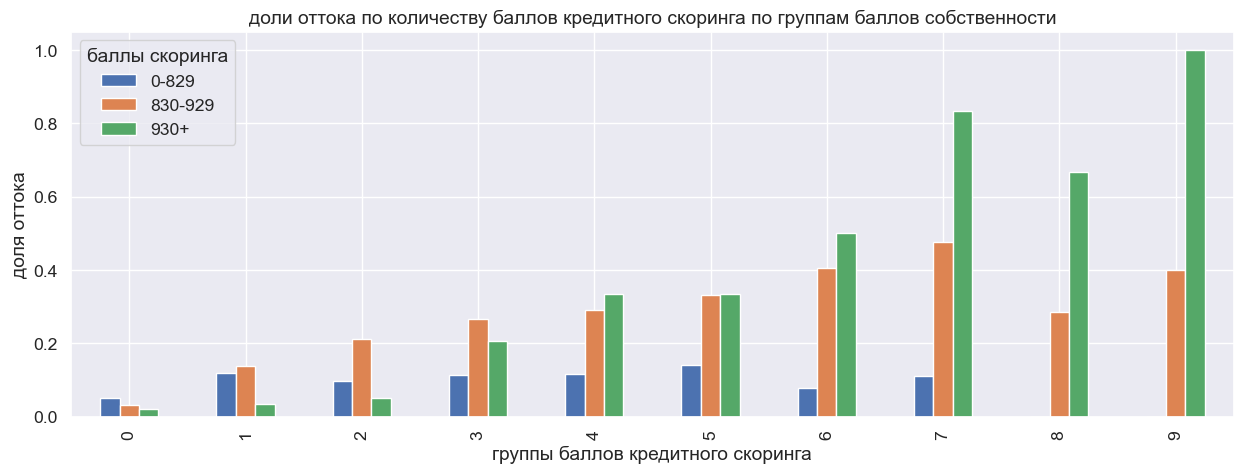

In [127]:
display(data.pivot_table(index = 'equity', columns = 'score_group', values = 'churn', aggfunc = ('count','mean')))

data.pivot_table(index = 'equity', columns = 'score_group', values = 'churn', aggfunc = 'mean').plot(kind = 'bar', figsize=(15,5))
plt.title('доли оттока по количеству баллов кредитного скоринга по группам баллов собственности')
plt.xlabel('группы баллов кредитного скоринга')
plt.ylabel('доля оттока')

plt.legend(title='баллы скоринга') 
plt.show()

По графику хорошо видно, что с ростом баллов собственности начиная с 4 и ростом баллов кредитног скоринга растет доля оттока 

**Общий вывод по сегментам:** 
- существует прямая связь между ростом количества испольуземых продуктов и ростом оттока клиентов. Чем больше продуктов клиент использует, тем выше вероятность его ухода, особенно если качество обслуживания не соответствует ожиданиям
- существует прямая связь между ростом количества баллов собственности и ростом оттока клиентов
- существует прямая связь между активностью клиентов и ростом оттока клиентов
- существует прямая связь между ростом количества баллов кредитного скоринга и ростом оттока клиентов
- влияние возраста на отток клиент не имеет линейной зависимости, во всех сегментах за исключением 65+ отток 20%

Чем больше продуктов клиент использует, тем выше вероятность его ухода, особенно если качество обслуживания не соответствует ожиданиям. Клиенты с высоким уровнем благосостояния (баллы собственности) и кредитоспособности (кредитный скоринг) более требовательны к качеству услуг и склонны к уходу при неудовлетворительном опыте.Для клиентов с низким количеством продуктов (0–1) и высокими баллами собственности или кредитного скоринга отток особенно высок. Это указывает на возможные проблемы с первичным взаимодействием (например, сложности при оформлении первого продукта). Неактивные клиенты с 4–5 продуктами часто покидают банк, что может быть связано с навязыванием дополнительных продуктов или их ненужностью.

## Проверка гиптез

### Проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались

Проверим нкак распределены выбороки группы отток и группы остались

Средняя остались:  147674.63788105457
Средняя отток:  148289.70222100057
Средняя остались:  118227.6
Средняя отток:  125395.22


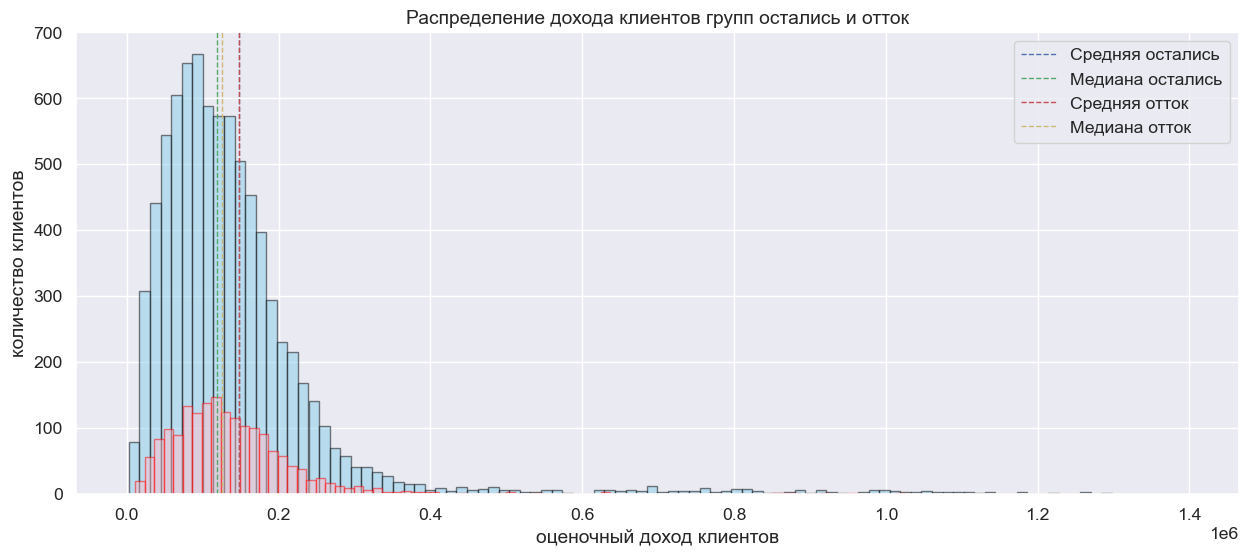

In [133]:
plt.figure(figsize=(15,6))

mean1 = np.mean(data.query('churn == 0')['est_salary'])
mean2 = np.mean(data.query('churn == 1')['est_salary'])

median1 = np.median(data.query('churn == 0')['est_salary'])
median2 = np.median(data.query('churn == 1')['est_salary'])

plt.hist(data.query('churn == 0')['est_salary'], bins=100, color='skyblue', edgecolor='black',alpha=0.5)
plt.axvline(mean1, color='b', linestyle='dashed', linewidth=1, label=f'Средняя остались')
plt.axvline(median1, color='g', linestyle='dashed', linewidth=1, label=f'Медиана остались')

plt.hist(data.query('churn == 1')['est_salary'], bins=100, color='pink', edgecolor='red',alpha=0.5)
plt.axvline(mean2, color='r', linestyle='dashed', linewidth=1, label=f'Средняя отток')
plt.axvline(median2, color='y', linestyle='dashed', linewidth=1, label=f'Медиана отток')

print('Средняя остались: ', mean1)
print('Средняя отток: ', mean2)
print('Средняя остались: ', median1)
print('Средняя отток: ', median2)

plt.title('Распределение дохода клиентов групп остались и отток')
plt.xlabel('оценочный доход клиентов')
plt.ylabel('количество клиентов')
plt.legend()
plt.show()

In [134]:
display(data.query('churn == 0')['est_salary'].describe())
display(data.query('churn == 1')['est_salary'].describe())

count      8155.0
mean     147674.6
std      142684.4
min        2546.3
25%       73445.6
50%      118227.6
75%      173960.9
max     1395064.4
Name: est_salary, dtype: float64

count      1819.0
mean     148289.7
std      122932.2
min       10880.3
25%       83196.6
50%      125395.2
75%      175985.4
max     1263028.5
Name: est_salary, dtype: float64

Размеры выборок группы остались и группы отток 8155 и 1819 соответственно. Разниуа почти в 4 раза. Показатели средних доходов 147674.6 и 148289.7 соответственно, медианы 118227.6 и 125395.2 соответственно. Стандартное отклонение выборки остались - 142684.4, отток - 122932.2. Выбросы значительные. 

Параметр оценочный доход `est_salary` имеет значительное количестов выбросов. Корректнее сравнивать медаинное значение. В данном случае используем для сравнение тест Манна-Уитни

Гипотеза:Медианные значения доходов между теми клиентами, которые ушли и теми, которые остались не равны

Нулевая гипотеза (H0): Медианные значения доходов между теми клиентами, которые ушли и теми, которые остались равны

Альтернативная гипотеза (H1): - Медианные значения доходов между теми клиентами, которые ушли и теми, которые остались не равны

Зададим уровень статистической значимость 5%.

In [138]:

alpha = 0.05 # уровень статистической значимости

results = st.mannwhitneyu(data.query('churn == 0')['est_salary'], data.query('churn == 1')['est_salary'], alternative='two-sided')

print('средний доход группы остались:', data.query('churn == 0')['est_salary'].mean())
print('средний доход группы отток:', data.query('churn == 1')['est_salary'].mean())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

средний доход группы остались: 147674.63788105457
средний доход группы отток: 148289.70222100057
p-значение: 0.0001941125216825749
Отвергаем нулевую гипотезу


p-значение: 0.00019, значительно ниже заданного уровня стат.значимости 5%. Отвергаем нулевую гипотезу, есть основания полагать, что медианным значениям оценочных доходов не равны. Начальная гипотеза не подтверждена.

### Проверить гипотезу различия баллов кредитного рейтинга группы остались и группы отток

Средняя остались:  845.3961986511342
Средняя отток:  863.416162726773
Средняя остались:  848.0
Средняя отток:  866.0


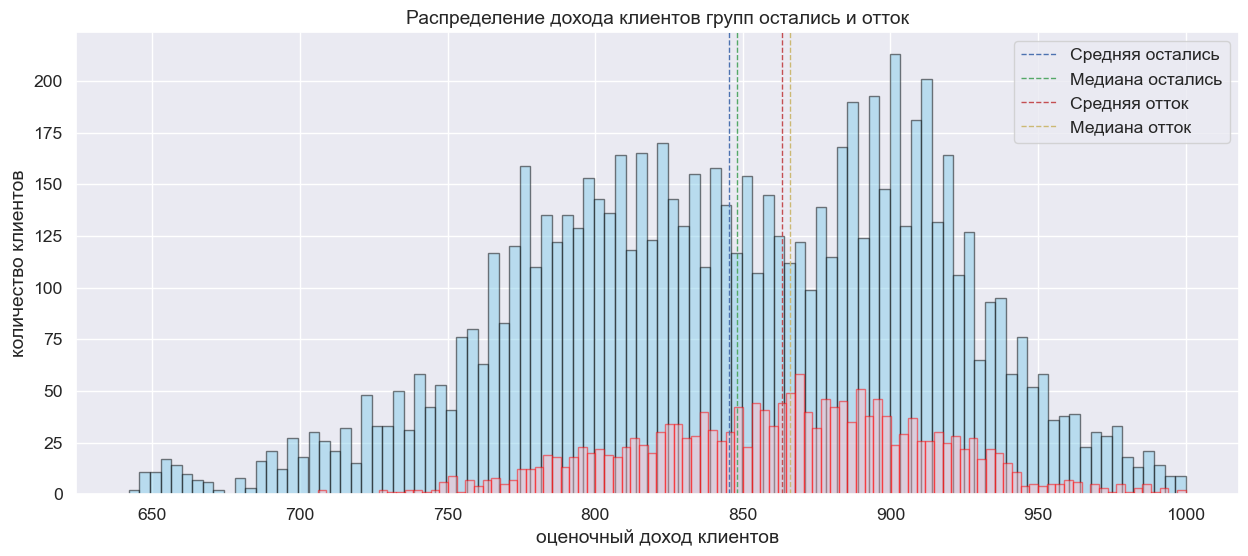

In [142]:
plt.figure(figsize=(15,6))

mean1 = np.mean(data.query('churn == 0')['score'])
mean2 = np.mean(data.query('churn == 1')['score'])

median1 = np.median(data.query('churn == 0')['score'])
median2 = np.median(data.query('churn == 1')['score'])

plt.hist(data.query('churn == 0')['score'], bins=100, color='skyblue', edgecolor='black',alpha=0.5)
plt.axvline(mean1, color='b', linestyle='dashed', linewidth=1, label=f'Средняя остались')
plt.axvline(median1, color='g', linestyle='dashed', linewidth=1, label=f'Медиана остались')

plt.hist(data.query('churn == 1')['score'], bins=100, color='pink', edgecolor='red',alpha=0.5)
plt.axvline(mean2, color='r', linestyle='dashed', linewidth=1, label=f'Средняя отток')
plt.axvline(median2, color='y', linestyle='dashed', linewidth=1, label=f'Медиана отток')

print('Средняя остались: ', mean1)
print('Средняя отток: ', mean2)
print('Средняя остались: ', median1)
print('Средняя отток: ', median2)

plt.title('Распределение дохода клиентов групп остались и отток')
plt.xlabel('оценочный доход клиентов')
plt.ylabel('количество клиентов')
plt.legend()
plt.show()

In [143]:
display(data.query('churn == 0')['score'].describe())
display(data.query('churn == 1')['score'].describe())

count   8155.0
mean     845.4
std       68.0
min      642.0
25%      796.0
50%      848.0
75%      900.0
max     1000.0
Name: score, dtype: float64

count   1819.0
mean     863.4
std       49.6
min      706.0
25%      828.0
50%      866.0
75%      898.0
max     1000.0
Name: score, dtype: float64

Размеры выборок группы остались и группы отток 8155 и 1819 соответственно. Разница почти в 4 раза. Показатели средних баллов скоринга 845.4 и 863.4 соответственно, медианы 848.0 и 866.0 соответственно. Стандартное отклонение выборки остались - 68, отток - 49. Выбросы отсутствуют

Параметр количество баллов скоринга `score` не имеет выбросов. Допустимо сравнивать средне значение. В данном случае используем для сравнение тест Стюдента

Гипотеза:Средние значения баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались не равны

Нулевая гипотеза (H0): Средние значения баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались равны

Альтернативная гипотеза (H1): - Средние значения баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались не равны

Зададим уровень статистической значимость 5%.

In [147]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(data.query('churn == 0')['score'], data.query('churn == 1')['score'], alternative='two-sided',equal_var=True)

print('средний доход группы остались:', data.query('churn == 0')['score'].mean())
print('средний доход группы отток:', data.query('churn == 1')['score'].mean())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

средний доход группы остались: 845.3961986511342
средний доход группы отток: 863.416162726773
p-значение: 1.6434640811160013e-26
Отвергаем нулевую гипотезу


p-значение: 1.6434640811160013e-26, значительно ниже заданного уровня стат.значимости 5%. Отвергаем нулевую гипотезу, есть основания полагать, что средние значения баллов кредитного скоринга не равны. Начальная гипотеза подтверждена.

### Проверить гипотезу различия количества продуктов группы остались и группы отток

Средняя остались:  1.7589209074187615
Средняя отток:  2.376030786146234
Средняя остались:  2.0
Средняя отток:  2.0


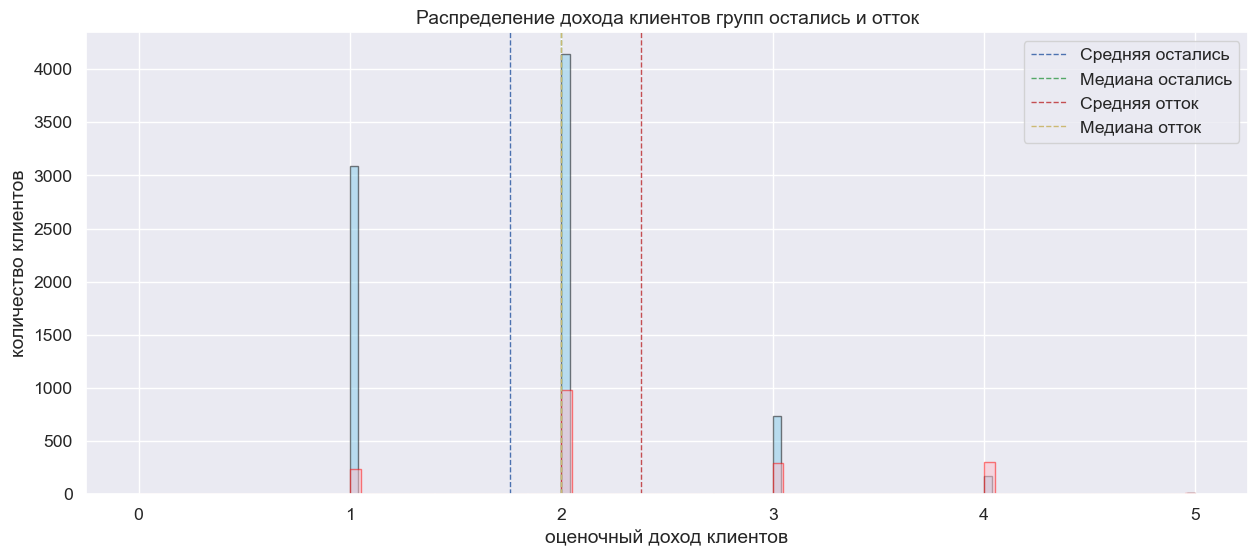

In [150]:
plt.figure(figsize=(15,6))

mean1 = np.mean(data.query('churn == 0')['products'])
mean2 = np.mean(data.query('churn == 1')['products'])

median1 = np.median(data.query('churn == 0')['products'])
median2 = np.median(data.query('churn == 1')['products'])

plt.hist(data.query('churn == 0')['products'], bins=100, color='skyblue', edgecolor='black',alpha=0.5)
plt.axvline(mean1, color='b', linestyle='dashed', linewidth=1, label=f'Средняя остались')
plt.axvline(median1, color='g', linestyle='dashed', linewidth=1, label=f'Медиана остались')

plt.hist(data.query('churn == 1')['products'], bins=100, color='pink', edgecolor='red',alpha=0.5)
plt.axvline(mean2, color='r', linestyle='dashed', linewidth=1, label=f'Средняя отток')
plt.axvline(median2, color='y', linestyle='dashed', linewidth=1, label=f'Медиана отток')

print('Средняя остались: ', mean1)
print('Средняя отток: ', mean2)
print('Средняя остались: ', median1)
print('Средняя отток: ', median2)

plt.title('Распределение дохода клиентов групп остались и отток')
plt.xlabel('оценочный доход клиентов')
plt.ylabel('количество клиентов')
plt.legend()
plt.show()

In [151]:
display(data.query('churn == 0')['products'].describe())
display(data.query('churn == 1')['products'].describe())

count   8155.0
mean       1.8
std        0.7
min        1.0
25%        1.0
50%        2.0
75%        2.0
max        5.0
Name: products, dtype: float64

count   1819.0
mean       2.4
std        0.9
min        0.0
25%        2.0
50%        2.0
75%        3.0
max        5.0
Name: products, dtype: float64

Размеры выборок группы остались и группы отток 8155 и 1819 соответственно. Разница почти в 4 раза. Показатели средних количества продуктов 1.8 и 2.4 соответственно, медианы равны 2 . Стандартное отклонение выборки остались - 0.9, отток - 0.7. Выбросы отсутствуют.

Параметр количество банковских продуктов `products` не имеет выбросов. Допустимо сравнивать средне значение. В данном случае используем для сравнение тест Стюдента

Гипотеза:Средние значения количества продуктов между теми клиентами, которые ушли и теми, которые остались не равны

Нулевая гипотеза (H0): Средние значения количества продуктов между теми клиентами, которые ушли и теми, которые остались равны

Альтернативная гипотеза (H1): - Средние значения количества продуктов между теми клиентами, которые ушли и теми, которые остались не равны

Зададим уровень статистической значимость 5%

In [155]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(data.query('churn == 0')['products'], data.query('churn == 1')['products'], alternative='two-sided',equal_var=True)

print('средний доход группы остались:', data.query('churn == 0')['products'].mean())
print('средний доход группы отток:', data.query('churn == 1')['products'].mean())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

средний доход группы остались: 1.7589209074187615
средний доход группы отток: 2.376030786146234
p-значение: 2.0765646697701624e-207
Отвергаем нулевую гипотезу


p-значение:  2.0765646697701624e-207, значительно ниже заданного уровня стат.значимости 5%. Отвергаем нулевую гипотезу, есть основания полагать, что средние значения баллов кредитного скоринга не равны. Начальная гипотеза подтверждена.

## Общие выводы и рекомендации

Основная масса клиентов сконцентрирована по параметру баллов кредитного рейтинга в диапазоне от примерно 770 до примерно 980.

В выборке присутствует только 3 города: 'Рыбинск', 'Ярославль', 'Ростов'. Наибольшее количество клиентов в Ярославле 5875 клиентов, далее следует Рыбинск 2683 и Ростов - 1416 клиентов

Только 2 гендера 'Ж', 'М'. Клиенты банка по полу распределены примерно одинаково - 4983 и 4991 клиентов соответственно.

Большинство клиентов по возрасту находятся в диапазоне от примерно 27 до примерно 50 лет.

По критерию количества баллов собственности наибольшая доля имеет оценку 0 баллов. Медиана по этому показателю составляет 3 балла собственности. Наличие 6-8 баллов имеет очень малая доля клиентов

Баланс большинства клиентов находится в диапазоне от примерно 50000-500000. Обращает на себя внимание большое количетсов лкиентов с нулевым или околонулевым остатком

Распределение оценочного дохода в большинстве своем распределено до 4000000, все что больше не многочисленны. Основная масса клиентов имеет оценочный доход в диапазоне примерно 75000-175000

Наибольшая часть клиентов банка пользуется двеся проудктами банка, реже имеет только 1 продукт.

По наличию кредитной карты приобладают среди клиентов ее обладатели 68% против 32% без кредитной карты.

Распределение клиентов по параметру активности близки, но преобладают активные клиенты - 52% против 48% неактивных клиентов

В группу отток попадают 18% всех клиентов или 1819 из 9974.

**Типичный клиента банка:** это активный клиент мужчина или женщина в возрасте 27-50 лет, с доходом 75000-175000, балансом счета 50000-500000, имеет 770-980 баллов кредитного скоринга, 4-5 баллов собственности, часто 0 баллов собственности, пользуется 2 банковскими продуктами, имеет кредитную карту



**Типичный портрет клиента группы отток:** это клиенты с довольно высоким баллом кредитного скоринга. Диапазон баллов 850-910. Чаще это мужчины в возррасте 27-45 лет и у старшего поколения в диапазоне 50-60 лет также значительный отток, имеюют 5 реже 4 балла собственности, пользуются 2 и более банковскими продуктами, чаще не имеет кредитной карты, это активные клиенты. Имеет доход 75000-130000, баланс счета 200000-500000

**Типичный портрет клиента группы оставшиеся:** активные клиенты в возрасте 27-45, чаще это женщины, имеет кредитную карту, пользуется 2 и более банковскими продуктами, имеет 0 или 5 баллов собственности. Клиенты группы оставшиеся в большинстве своем имеют балыы кредитного скорринга в диапазоне 770-910, неактивные клиенты. Имеет доход 50000-150000, баланс счета 200000-500000

Характерная особенность группы отток это более активные клиенты в возрасте 27-45, пользуются 2 и более банковскими продуктамии меют 5 баллов собственности. Вероятно имеют определенные тредования к имющимся банковсим продуктам и уходят в другие банки в поисках луших условий и/или сервиса

Основные параметры влияющие на отток:
- наибольшая корреляця 44% наблюдается с количеством банковских продуктов products , котрыми пользуется клиент, чем больше продукто клиент использует тем выше лояльность к выбранному банку, тем ниже вероятность попасть в группу отток
- количество баллов собственности equity- корреляция 35%, вероятно чем больше баллов тем ниже отток, клиенту важна стабильность, такой клиент менее подвержен к переменнам в т.ч. смены банка
- активный клиент last_activity 26% корреляция - чем чаще клиент пользуется услугами конкретного банка, тем выше его лояльность, тем меньше вероятность сменить банк
- баллы кредитного скоринга score - корреляция 23% - чем выше балл тем более вероято клиент может получать кредитные продукты по более лояльной ставке кредита, либо это могут быть дополнительные бонусы, что также положительно скажется на лояльности клиента
- корреляция gender пола составляет 22%, в действительность как можно наблюдать на графике, мужчины несколько чаще склонны менять банк, чем женщины
- age возраст также оказывает вляние на вероятность оттока клиентов, корреляция составляет 19%

Влияние параметров на отток:
- существует прямая связь между ростом количества испольуземых продуктов и ростом оттока клиентов. Чем больше продуктов клиент использует, тем выше вероятность его ухода, особенно если качество обслуживания не соответствует ожиданиям
- существует прямая связь между ростом количества баллов собственности и ростом оттока клиентов
- существует прямая связь между активностью клиентов и ростом оттока клиентов
- существует прямая связь между ростом количества баллов кредитного скоринга и ростом оттока клиентов
- влияние возраста на отток клиент не имеет линейной зависимости, во всех сегментах за исключением 65+ отток 20%


Чем больше продуктов клиент использует, тем выше вероятность его ухода, особенно если качество обслуживания не соответствует ожиданиям. Клиенты с высоким уровнем благосостояния (баллы собственности) и кредитоспособности (кредитный скоринг) более требовательны к качеству услуг и склонны к уходу при неудовлетворительном опыте.Для клиентов с низким количеством продуктов (0–1) и высокими баллами собственности или кредитного скоринга отток особенно высок. Это указывает на возможные проблемы с первичным взаимодействием (например, сложности при оформлении первого продукта). Неактивные клиенты с 4–5 продуктами часто покидают банк, что может быть связано с навязыванием дополнительных продуктов или их ненужностью.


**В качестве рекомендаций следует выделить следующие направления:**

**Улучшение качества обслуживания и персонализация услуг:**
- Особое внимание следует уделить клиентам с высоким кредитным скорингом и баллами собственности. Для них важно предлагать премиальные продукты, персонализированные условия и высокий уровень сервиса.
- Внедрить программы лояльности для активных клиентов, чтобы повысить их удовлетворенность и снизить вероятность ухода.

**Оптимизация процесса продажи продуктов :**
- Избегать навязывания ненужных продуктов, особенно для клиентов с высоким уровнем благосостояния. Каждый продукт должен быть целесообразным и полезным для клиента.
- Разработать программы по активизации неактивных клиентов, например, через специальные предложения или бонусы.

**Фокус на начальном взаимодействии :**

- Упростить процесс оформления первого продукта и обеспечить качественную поддержку на этапе начала взаимодействия с банком.
- Провести анализ причин ухода клиентов с низким количеством продуктов (0–1) и разработать стратегии их удержания.

**Анализ проблемных групп :**
- Провести детальное исследование причин ухода неактивных клиентов с большим количеством продуктов (4–5). Возможно, стоит разработать программы по их активизации или отказаться от ненужных продуктов.

**Сегментация и персонализация :**
- Разработать стратегии удержания для ключевых сегментов клиентов (например, с высоким кредитным скорингом и баллами собственности).
- Использовать кросс-сегментацию для выявления скрытых закономерностей и взаимосвязей между различными параметрами.

**Мониторинг возраста клиентов :**

Особое внимание уделить клиентам в возрасте 27–45 лет и 50–60 лет, так как они демонстрируют повышенный уровень оттока. Для этих групп можно разработать специальные предложения, учитывающие их потребности.


**Для снижения оттока необходимо сосредоточиться на улучшении качества обслуживания, персонализации предложений и оптимизации процессов взаимодействия с клиентами, особенно для высокоценных сегментов**